What is the point of this?

1) Prove that streaming in more data decreases MSE
- break down into separate functions that operate on ALS model for convertibility purposes
2) Convertable to Ralf.
- What is the structure of a Ralf experiment
- Source --> Passes down Record that has rating, movie, user
- BiasOperator --> Predicts, Updates Biases, passes down record that stores 

Predicting needs: biases, item vectors, user vectors
Bias Updating needs: user bias, item bias, error, learning rate, bias regularization terms
Factor Updating needs: error, learning rate, factor regularization terms, item vectors, user vectors

where can these vectors stay taht are stored and accessible across all? to ask in research meeting




Notes
- maybe don't update movie vector?
- define source tables
- one table for user vectors (maybe store bias and features in the same row)
- one table for movie vectors
- try only updating user vectors with 1/2-1/2 split
- hav some pretrained model, movies not updated
- ralf server takes source, updates the original user vectors
- proper way is to point query own model, but for now it's stored as map inside operator
- operation might be too cheap, too fast in comparision with ralf overhead. could make operator artificially expensive?

Next Step:
    - research meeting tomorrow, maybe make some slides/present this?
    - use it with pre-computed movie vectors/biases 
    - what the distribution of updates are, if a lot of space between updates — need high density stream
        - need workload/updates to be hard, if it's trivial then there's no need, maybe not system problem? examine workload closer
        - could up features?
        - time each individual update and see (with movies)
    - should port to RALF first? might have to wait for simon to finish refactor
    - maybe one operator (update both vector & bias)?
    - if you had movie/user feature vector then you have different primary keys?
    - is it acceptable to point query another table?
        - source --> user --> movie

In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

In [10]:
# Download from Kaggle: https://www.kaggle.com/prajitdatta/movielens-100k-dataset
ratings_path = "/Users/amitnarang/Downloads/ml-100k/u.data"

In [17]:
columns=["user_id", "movie_id", "rating", "timestamp"]
df = pd.read_csv(ratings_path, sep = '\t')

In [18]:
df.sort_values('timestamp').head(100)['user_id'].unique()

array([259, 851, 712])

In [19]:
def split_train_test(df, num_test, num_users):
    columns = list(df.columns)
    train_data = []
    test_data = []
    for user_id in df["user_id"].unique():
        user_df = df[df["user_id"] == user_id].sort_values("timestamp")
        last_rows = user_df.tail(num_test)
        for row in user_df.itertuples():
            if row.user_id < num_users:
                data = [row.user_id, row.movie_id, row.rating, row.timestamp]
                if any(last_rows["movie_id"] == row.movie_id):
                    test_data.append(data)
                else:
                    train_data.append(data)
    train_df = pd.DataFrame(data=train_data, columns=columns).sort_values("timestamp")
    train_df = train_df.sample(frac=1)
    test_df = pd.DataFrame(data=test_data, columns=columns)
    return train_df, test_df

In [20]:
train_df, test_df = split_train_test(df, 5, 1000)
num_users = max(df['user_id'])
num_movies = max(df['movie_id'])

how to handle streaming sgd?

as we stream in a rating, update that movie's vector, that movie's bias, that user's vector, that user's bias

In [21]:
class ALSStreamingModel():
    
    def __init__(self, train_data, test_data, num_users, num_movies, num_features, learning_rate, user_bias_reg, movie_bias_reg, user_feature_reg, movie_feature_reg):
        self.train_data = train_data
        self.test_data = test_data
        self.num_users = num_users + 1
        self.num_movies = num_movies + 1
        self.learning_rate = learning_rate
        self.num_features = num_features
        
        self.global_bias = np.average(train_data['rating'])
        self.user_bias = np.zeros(self.num_users)
        self.movie_bias = np.zeros(self.num_movies)
        self.user_bias_reg = user_bias_reg
        self.movie_bias_reg = movie_bias_reg
        
        # make movie vectors initialiazble, global bias = avg(rating)
        self.user_vectors = np.random.normal(scale=1./self.num_features, size=(self.num_users, self.num_features))
        self.movie_vectors = np.random.normal(scale=1./self.num_features, size=(self.num_movies, self.num_features))
        self.user_feature_reg = user_feature_reg
        self.movie_feature_reg = movie_feature_reg
    
    def train(self):
        mse = []
        for row in self.train_data.itertuples():
            curr = time.time()
            if row.Index % 10 == 0:
                mse.append(self.compute_test_mse())
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            self.step(user_id, movie_id, rating)
            print(time.time()-curr)
        self.test_mse_record = mse
            
    def update_bias(self, user_id, movie_id, error):
        self.user_bias[user_id] += self.learning_rate * (error - self.user_bias_reg * self.user_bias[user_id])
        #self.movie_bias[movie_id] += self.learning_rate * (error - self.movie_bias_reg * self.movie_bias[movie_id])
    
    def update_features(self, user_id, movie_id, error):
        self.user_vectors[user_id, :] += self.learning_rate * (error * self.movie_vectors[movie_id, :] - self.user_feature_reg * self.user_vectors[user_id,:])
        #self.movie_vectors[movie_id, :] += self.learning_rate * (error * self.user_vectors[user_id, :] - self.movie_feature_reg * self.movie_vectors[movie_id,:])
        
    def predict_rating(self, user_id, movie_id):
        biases = self.global_bias + self.user_bias[user_id] # + self.movie_bias[movie_id]
        prediction = self.user_vectors[user_id].dot(self.movie_vectors[movie_id].T)
        return biases + prediction
    
    def compute_prediction_error(self, user_id, movie_id, rating):
        prediction = self.predict_rating(user_id, movie_id)
        return rating - prediction
    
    def step(self, user_id, movie_id, rating):
        error = self.compute_prediction_error(user_id, movie_id, rating)
        self.update_bias(user_id, movie_id, error)
        self.update_features(user_id, movie_id, error)
            
    def compute_test_mse(self):
        predictions = []
        ratings = []
        for row in self.test_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(self.predict_rating(user_id, movie_id))
            ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse
    
    def compute_train_mse(self):
        predictions = []
        ratings = []
        for row in self.train_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(self.predict_rating(user_id, movie_id))
            ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse

In [22]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

In [23]:
def generate_optimal_hyperparameters():
    learning_rates = [1e-3, 1e-2, 1e-1]
    user_bias_reg = [1e-2, 1e-1, 2e-1]
    movie_bias_reg = [1e-2, 1e-1, 2e-1]
    user_feature_reg = [1e-2, 1e-1, 2e-1]
    movie_feature_reg = [1e-2, 1e-1, 2e-1]

    best_params = {}
    best_params['learning_rate'] = None
    best_params['user_bias_reg'] = None
    best_params['movie_bias_reg'] = None
    best_params['user_feature_reg'] = None
    best_params['movie_feature_reg'] = None
    best_params['train_mse'] = np.inf
    best_params['test_mse'] = np.inf
    best_params['model'] = None


    for rate in learning_rates:
        print(rate)
        for ubreg in user_bias_reg:
            for mbreg in movie_bias_reg:
                for ufreg in user_feature_reg:
                    for mfreg in movie_feature_reg:
                        als = ALSStreamingModel(train_df, test_df, num_users, num_movies, 40, rate, ubreg, mbreg, ufreg, mfreg)
                        als.train()
                        test_mse = als.compute_test_mse()
                        if test_mse < best_params['test_mse']:
                            best_params['test_mse'] = test_mse
                            best_params['learning_rate'] = rate
                            best_params['train_mse'] = als.compute_train_mse()
                            best_params['user_bias_reg'] = ubreg
                            best_params['movie_bias_reg'] = mbreg
                            best_params['user_feature_reg'] = ufreg
                            best_params['movie_feature_reg'] = mfreg
                            best_params['model'] = als
                            print("New optimal parameters")
    return best_params

In [24]:
optimal_learning_rate = .1
optimal_ub_reg = .1
optimal_mb_reg = .01
optimal_uf_reg = .01
optimal_mf_reg = .1
train_df, test_df = train_df, test_df = split_train_test(df, 5, np.inf) 
als = ALSStreamingModel(train_df, test_df, num_users, num_movies, 100, optimal_learning_rate, optimal_ub_reg, optimal_mb_reg, optimal_uf_reg, optimal_mf_reg)
als.train()

3.933906555175781e-05
1.0013580322265625e-05
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
6.9141387939453125e-06
4.76837158203125e-06
5.0067901611328125e-06
0.009753942489624023
1.1920928955078125e-05
7.3909759521484375e-06
6.198883056640625e-06
0.007312297821044922
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
0.00908207893371582
1.0013580322265625e-05
7.152557373046875e-06
0.00798797607421875
8.821487426757812e-06
0.006707906723022461
0.006117105484008789
7.867813110351562e-06
0.006261110305786133
6.9141387939453125e-06
6.198883056640625e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
0.00935506820678711
1.0967254638671875e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
6.1

0.010229110717773438
9.298324584960938e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
4.76837158203125e-06
7.867813110351562e-06
5.9604644775390625e-06
0.011271238327026367
1.0013580322265625e-05
4.00543212890625e-05
8.106231689453125e-06
6.9141387939453125e-06
0.008333921432495117
7.867813110351562e-06
5.7220458984375e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
1.0013580322265625e-05
0.009280920028686523
0.00642085075378418
1.0967254638671875e-05
5.9604644775390625e-06
6.198883056640625e-06
5.7220458984375e-06
4.76837158203125e-06
7.867813110351562e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
5.9604644775390625e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e

0.00956583023071289
0.010822057723999023
1.1920928955078125e-05
8.106231689453125e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.011840581893920898
8.821487426757812e-06
5.7220458984375e-06
6.198883056640625e-06
7.867813110351562e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.010209083557128906
9.059906005859375e-06
6.198883056640625e-06
1.2159347534179688e-05
6.9141387939453125e-06
4.76837158203125e-06
5.7220458984375e-06
5.7220458984375e-06
0.009943723678588867
1.0013580322265625e-05
7.152557373046875e-06
9.059906005859375e-06
5.9604644775390625e-06
0.010031938552856445
9.059906005859375e-06
5.9604644775390625e-06
0.010109186172485352
8.821487426757812e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
8.344650268554

0.00959014892578125
0.010843992233276367
1.9073486328125e-05
6.9141387939453125e-06
9.059906005859375e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
7.152557373046875e-06
5.9604644775390625e-06
7.867813110351562e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
0.012972831726074219
9.059906005859375e-06
1.0013580322265625e-05
6.198883056640625e-06
6.9141387939453125e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
1.4781951904296875e-05
7.152557373046875e-06
6.9141387939453125e-06
5.7220458984375e-06
5.96

0.00947880744934082
1.0013580322265625e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
0.010299205780029297
1.0967254638671875e-05
5.9604644775390625e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.01253199577331543
7.867813110351562e-06
5.245208740234375e-06
0.006748199462890625
2.47955322265625e-05
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
0.00975489616394043
8.106231689453125e-06
6.198883056640625e-06
8.106231689453125e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
0.00954294204711914
8.82148742

0.009981870651245117
9.298324584960938e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
1.0013580322265625e-05
0.011185169219970703
1.4781951904296875e-05
1.9073486328125e-05
0.00989389419555664
8.821487426757812e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
7.152557373046875e-06
1.0013580322265625e-05
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
7.152557373046875e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
7.867813110351562e-06
2.47955322265625e-05
1.0967254638671875e-05
5.9604644775390625e-06
6.198883056640625e-06
0.0

0.0077190399169921875
1.0967254638671875e-05
7.3909759521484375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.01003408432006836
9.298324584960938e-06
6.9141387939453125e-06
7.152557373046875e-06
6.9141387939453125e-06
7.152557373046875e-06
7.152557373046875e-06
0.007993698120117188
2.7894973754882812e-05
1.0013580322265625e-05
5.9604644775390625e-06
8.106231689453125e-06
9.059906005859375e-06
0.007904052734375
9.059906005859375e-06
6.9141387939453125e-06
6.9141387939453125e-06
8.106231689453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
0.008248090744018555
1.1205673217773438e-05
1.2159347534179688e-05
1.0013580322265625e-05
5.0067901611328125e-06
5.245208740234375e-06
0.008349180221557617
7.867813110351562e-06
7.867813110351562e-06
8.106231689453125e-06
6.9141387939453125e-06
0.0070667266845703125
8.106231689453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.19

0.010465860366821289
1.8835067749023438e-05
7.867813110351562e-06
7.3909759521484375e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
1.1205673217773438e-05
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
6.9141387939453125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.245208740234375e-06
0.010362863540649414
8.821487426757812e-06
7.152557373046875e-06
6.198883056640625e-06
4.76837158203125e-06
5.7220458984375e-06

0.007860898971557617
0.00693202018737793
6.9141387939453125e-06
6.198883056640625e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
0.008147001266479492
9.059906005859375e-06
6.198883056640625e-06
0.0068569183349609375
6.9141387939453125e-06
7.152557373046875e-06
0.007171154022216797
6.9141387939453125e-06
5.245208740234375e-06
6.198883056640625e-06
0.006985902786254883
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
5.9604644775390625e-06
0.009153604507446289
9.059906005859375e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
5.0067901611328125e-06
4.768

0.009910106658935547
8.106231689453125e-06
0.00772404670715332
1.0013580322265625e-05
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
0.008213996887207031
7.867813110351562e-06
1.3113021850585938e-05
7.152557373046875e-06
1.1920928955078125e-05
0.006963968276977539
7.867813110351562e-06
0.006693124771118164
7.3909759521484375e-06
8.821487426757812e-06
6.9141387939453125e-06
5.9604644775390625e-06
7.867813110351562e-06
7.152557373046875e-06
5.0067901611328125e-06
0.009172916412353516
8.821487426757812e-06
5.9604644775390625e-06
7.3909759521484375e-06
6.198883056640625e-06
1.0013580322265625e-05
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.198883056640625e-06
6.9141387939453125e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
4.768

0.009488821029663086
1.6927719116210938e-05
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
0.009186983108520508
7.152557373046875e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
8.821487426757812e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
9.059906005859375e-06
8.344650268554688e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
0.010055780410766602
9.059906005859375e-06
1.811981201171875e-05
7.3909759521484375e-06
6.198883056

0.010061979293823242
1.0013580322265625e-05
6.198883056640625e-06
6.9141387939453125e-06
0.009091615676879883
1.0013580322265625e-05
2.002716064453125e-05
7.867813110351562e-06
5.9604644775390625e-06
6.67572021484375e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.007643938064575195
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
0.007434844970703125
7.152557373046875e-06
6.198883056640625e-06
5.7220458984375e-06
9.059906005859375e-06
0.007189273834228516
7.152557373046875e-06
6.9141387939453125e-06
0.006696939468383789
7.152557373046875e-06
6.198883056640625e-06
1.0967254638671875e-05
6.9141387939453125e-06
4.76837158203125e-06
6.9141387939453125e-06
8.106231689453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
0.009353876113891602
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
8.10623

0.009731054306030273
9.298324584960938e-06
9.059906005859375e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
7.152557373046875e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
6.9141387939453125e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.7220458984375e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
5.245208740234375e-06
5.006790

0.009983062744140625
1.0013580322265625e-05
1.6927719116210938e-05
7.867813110351562e-06
6.9141387939453125e-06
9.059906005859375e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
8.821487426757812e-06
5.7220458984375e-06
5.9604644775390625e-06
0.013093948364257812
3.0040740966796875e-05
6.9141387939453125e-06
0.008274316787719727
3.409385681152344e-05
1.0013580322265625e-05
0.0069408416748046875
2.7179718017578125e-05
0.00701904296875
4.410743713378906e-05
1.1920928955078125e-05
6.9141387939453125e-06
0.008400917053222656
9.059906005859375e-06
8.821487426757812e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.245208740234375e-06
7.152557373046875e-06
6.198883056640625e-06
5.7220458984375e-06
4.76837158203125e-06
6.9141387939453125e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.010600090026855469
1.0013580322265625e-05
7.152557373046875e-06
0.008603334426879883
8.106231689453125e-06
6.914138793945

0.009817123413085938
1.0013580322265625e-05
6.9141387939453125e-06
0.011754989624023438
1.4066696166992188e-05
0.010869026184082031
8.106231689453125e-06
0.0067179203033447266
7.867813110351562e-06
0.006320953369140625
6.9141387939453125e-06
7.152557373046875e-06
1.5974044799804688e-05
6.9141387939453125e-06
0.007369041442871094
8.106231689453125e-06
5.9604644775390625e-06
9.059906005859375e-06
1.2159347534179688e-05
5.7220458984375e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.009370088577270508
9.298324584960938e-06
0.007920980453491211
6.9141387939453125e-06
9.059906005859375e-06
5.9604644775390625e-06
5.245208740234375e-06
8.106231689453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009351968765258789
1.1205673217773438e-05
6.9141387939453125e-06
5.9604644775390625e-06
1.0013580322265625e-05
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-0

0.010339021682739258
8.106231689453125e-06
8.821487426757812e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.011042118072509766
0.006465911865234375
2.7179718017578125e-05
0.0070819854736328125
7.867813110351562e-06
8.106231689453125e-06
1.0013580322265625e-05
6.198883056640625e-06
1.0967254638671875e-05
9.298324584960938e-06
5.7220458984375e-06
0.007578849792480469
6.9141387939453125e-06
6.9141387939453125e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.007131814956665039
6.9141387939453125e-06
6.9141387939453125e-06
9.059906005859375e-06
1.0013580322265625e-05
4.76837158203125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.245208740234375e-06
6.9141387939453125e-06
5.245208740234375e-06
5.9604644775390625e-06
0.00944209098815918
6.9141387939453125e-06
7.867813110351562e-06
5.9604644775390625e-06
9.059906005859375e-06
4.76837158203125e-06
5.0067901611328125e-06
5.9604644775390625e-06
8.106231689453125e-06
4.76837158203125e-06
5.96

0.010352849960327148
1.0013580322265625e-05
0.010931968688964844
1.0013580322265625e-05
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
0.010315895080566406
1.0013580322265625e-05
6.9141387939453125e-06
1.0013580322265625e-05
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
6.9141387939453125e-06
5.0067901611328125e-06
5.7220458984375e-06
0.008463859558105469
0.006337165832519531
6.9141387939453125e-06
0.006459951400756836
6.9141387939453125e-06
5.7220458984375e-06
0.007349729537963867
9.059906005859375e-06
5.7220458984375e-06
0.0073359012603759766
7.152557373046875e-06
9.059906005859375e-06
5.0067901611328125e-06
5.9604644775390625e-06
4.76837158203125e-06
8.106231689453125e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
8.106231689453125e-06
6.198883056640625e-06
5.0067901611328125e-06
5.245208740234375e-06
8.344650268554688e-06
0.009471893310

0.007984161376953125
6.9141387939453125e-06
5.9604644775390625e-06
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
7.152557373046875e-06
5.9604644775390625e-06
0.009057998657226562
2.4080276489257812e-05
5.9604644775390625e-06
0.0073528289794921875
0.006351947784423828
7.867813110351562e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.245208740234375e-06
5.0067901611328125e-06
5.245208740234375e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
0.010258913040161133
1.1920928955078125e-05
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
7.867813110351562e-06
4.76837158203125e-06
0.009437799453735352
9.059906005859375e-06
7.152557373046875e-06
8.344650268554688e-06
5.96

0.007196903228759766
8.106231689453125e-06
1.1920928955078125e-05
8.821487426757812e-06
6.9141387939453125e-06
1.0967254638671875e-05
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
6.198883056640625e-06
7.867813110351562e-06
0.009946107864379883
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
5.9604644775390625e-06
0.009274721145629883
8.106231689453125e-06
1.0967254638671875e-05
6.9141387939453125e-06
5.7220458984375e-06
9.059906005859375e-06
7.152557373046875e-06
6.198883056640625e-06
0.009186983108520508
8.821487426757812e-06
9.059906005859375e-06
6.9141387939453125e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
1.2159347534179688e-05
7.152557373046875e-06
1.0013580322265625e

0.009721040725708008
9.059906005859375e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
5.0067901611328125e-06
6.9141387939453125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
7.867813110351562e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.9141387939453125e-06
1.0728836059570312e-05
5.7220458984375e-06
5.9604644775390625e-06
8.106231689453125e-06
5.0067901611328125e-06
0.010991811752319336
1.1920928955078125e-05
6.9141387939453125e-06
5.9604644775390625e-06
7.3909759521484375e-06
5.245208740234375e-06
6.198883056640625e-06
5.0067901611328125e-06
8.916854858398438e-05
7.867813110351562e-06
0.010553836822509766
7.867813110351562e-06
8.821487426757812e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.245208740234

0.009666204452514648
9.059906005859375e-06
8.106231689453125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.0067901611328125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.245208740234375e-06
4.76837158203125e-06
7.867813110351562e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
8.106231689453125e-06
6.198883056640625e-06
8.106231689453125e-06
5.245208740234375e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
7.867813110351562e-06
5.0067901611328125e-06
5.0067901611328125e-06
0.0116729736328125
1.3828277587890625e-05
8.106231689453125e-06
5.9604644775390625e-06
5.

0.010043859481811523
9.059906005859375e-06
7.867813110351562e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
7.867813110351562e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
6.198883056640625e-06
8.106231689453125e-06
0.013384819030761719
9.059906005859375e-06
1.2159347534179688e-05
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
9.059906005859375e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
7.867813110351562e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
6.198883056640625e-06
0.010340213775634766
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.00679016

0.00980687141418457
1.0967254638671875e-05
5.9604644775390625e-06
5.9604644775390625e-06
8.821487426757812e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
7.867813110351562e-06
2.09808349609375e-05
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
0.010771036148071289
1.0013580322265625e-05
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
1.0013580322265625e-05
5.9604644775390625e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
0.01169896125793457
8.821487426757812e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
0.007160663604736328
7.867813110351562e-06
7.152557373046875e-06
6.9141387939453125e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
6.9141387939453125e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
7.8678131

0.00949406623840332
1.2159347534179688e-05
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
9.059906005859375e-06
0.010757207870483398
0.011972665786743164
9.059906005859375e-06
0.007941007614135742
1.0013580322265625e-05
0.006886005401611328
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
0.00709986686706543
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
0.006554841995239258
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.007134914398193359
6.9141387939453125e-06
8.106231689453125e-06
0.0070149898529052734
6.9141387939453125e-06
6.198883056640625e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
7.867813110351562e-06
5.7220458984375e-06
9.059906005859375e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
5.9604644775390625e-06
7.867813110351562e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
5.00679

0.009953022003173828
8.106231689453125e-06
0.011828899383544922
8.821487426757812e-06
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
9.775161743164062e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
0.008568286895751953
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
0.009572029113769531
8.821487426757812e-06
6.198883056640625e-06
5.245208740234375e-06
5.7220458984375e-06
7.867813110351562e-06
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
7.152557373046875e-06
5.0067901611328125e-06
7.867813110351562e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.152557373046875e-06
5.0067901611328125e-06
6.1988830566406

0.009855985641479492
8.821487426757812e-06
6.9141387939453125e-06
9.059906005859375e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
4.76837158203125e-06
7.867813110351562e-06
5.9604644775390625e-06
4.76837158203125e-06
7.867813110351562e-06
6.198883056640625e-06
5.9604644775390625e-06
9.298324584960938e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
5.0067901611328125e-06
5.7220458984375e-06
9.775161743164062e-06
7.152557373046875e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
7.867813110351562e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
7.867813110351562e-06

0.009948015213012695
1.1682510375976562e-05
9.059906005859375e-06
6.198883056640625e-06
6.198883056640625e-06
0.013520002365112305
1.1920928955078125e-05
1.1920928955078125e-05
6.9141387939453125e-06
6.9141387939453125e-06
8.821487426757812e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
7.867813110351562e-06
0.011092901229858398
1.0967254638671875e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.245208740234375e-06
5.9604644775390625e-06
8.106231689453125e-06
5.245208740234375e-06
8.344650268554688e-06
5.9604644775390625e-06
1.001358032

0.006919145584106445
8.106231689453125e-06
8.106231689453125e-06
4.76837158203125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
1.0013580322265625e-05
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
1.2159347534179688e-05
0.00963902473449707
9.059906005859375e-06
7.152557373046875e-06
0.009422063827514648
8.821487426757812e-06
6.9141387939453125e-06
7.152557373046875e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
7.867813110351562e-06
5.0067901611328125e-06
6.9141387939453125e-06
9.059906005859375e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
0.00988006591796875
8.344650268554688e-06
5.7220458984375e-06
6.9141387939453125e-06
5.245208740234375e-06
5.0067901611328125e-06
5.9604644775390625e-06
7.152557373046875e-06
0.009575128555297852
8.8214874

0.009734869003295898
8.821487426757812e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
8.106231689453125e-06
5.9604644775390625e-06
9.059906005859375e-06
5.245208740234375e-06
0.011045217514038086
1.9311904907226562e-05
9.775161743164062e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.7220458984375e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
4.76837158203125e-06
8.821487426757812e-06
8.821487426757812e-06
5.245208740234375e-06
6.198883056640625e-06
4.76837158203125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.011790037155151367
0.0102

0.00963902473449707
7.867813110351562e-06
5.7220458984375e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.007788181304931641
6.67572021484375e-06
5.245208740234375e-06
0.007454872131347656
7.152557373046875e-06
5.9604644775390625e-06
7.152557373046875e-06
5.245208740234375e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
7.867813110351562e-06
8.821487426757812e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
4.76837158203125e-06
0.009811878204345703
9.298324584960938e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
0.00944209098815918
8.821487426757812e-06
0.007050991058349609
6.9141387939453125e-06
5.9604644775390625e-06
7.152557373046875e-06
6.9141387939453125e-06
5.7220458984375e-06
5.7220458984375e

0.00790095329284668
8.106231689453125e-06
1.1205673217773438e-05
1.0967254638671875e-05
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
7.152557373046875e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
1.1205673217773438e-05
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
7.152557373046875e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
0.009490013122558594
1.0967254638671875e-05
7.867813110351562e-06
0.010673999786376953
1.1205673217773438e-05
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
8.106231689453125e-06
9.059906005859375e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
0.010282039642333984
8.10623168945

0.009367227554321289
9.059906005859375e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.010632991790771484
8.821487426757812e-06
7.152557373046875e-06
5.9604644775390625e-06
7.152557373046875e-06
0.010977983474731445
7.867813110351562e-06
7.152557373046875e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.009727954864501953
8.821487426757812e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
5.0067901611328125e-06
0.009534120559692383
7.867813110351562e-06
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.960464

0.009350061416625977
9.059906005859375e-06
5.9604644775390625e-06
0.00860905647277832
7.867813110351562e-06
7.152557373046875e-06
5.9604644775390625e-06
6.9141387939453125e-06
4.76837158203125e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
0.010432958602905273
1.0013580322265625e-05
6.198883056640625e-06
0.00763702392578125
7.867813110351562e-06
8.344650268554688e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
6.699562072753906e-05
7.152557373046875e-06
6.198883056640625e-06
0.009320974349975586
8.106231689453125e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
8.821487426757812e-06
6.198883056640625e-06
5.9604644775390625e-06
5.245208740234375e-06
0.008673906326293945
7.867813110

0.009224891662597656
7.867813110351562e-06
7.152557373046875e-06
6.198883056640625e-06
0.007336854934692383
0.006953001022338867
1.2159347534179688e-05
6.9141387939453125e-06
0.00689697265625
7.152557373046875e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
9.059906005859375e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
0.009350061416625977
8.106231689453125e-06
6.9141387939453125e-06
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
8.821487426757812e-06
6.198883056640625e-06
6.198883056640625e-06
0.00957798957824707
1.0013580322265625e-05
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
8.106231689453125e-06
7.152557373046875e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
0.009475946426

0.00987386703491211
8.106231689453125e-06
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
9.298324584960938e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
0.010834932327270508
7.867813110351562e-06
6.9141387939453125e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
7.152557373046875e-06
0.00761103630065918
1.0967254638671875e-05
7.152557373046875e-06
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.867813110351562e-06
5.245208740234375e-06
5.0067901611328125e-06
0.009584188461303711
1.4066696166992188e-05
0.008676767349243164
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
0.00884366

0.00954127311706543
8.821487426757812e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.9141387939453125e-06
4.76837158203125e-06
8.106231689453125e-06
5.9604644775390625e-06
1.0013580322265625e-05
0.010659933090209961
8.106231689453125e-06
7.152557373046875e-06
6.9141387939453125e-06
0.012531042098999023
1.0013580322265625e-05
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
7.152557373046875e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.9141387939453125e-06
0.008422136306762695
7.867813110351562e-06
5.7220458984375e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
1.0013580322265625e-05
5.00679

0.010555744171142578
1.0967254638671875e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.7220458984375e-06
5.9604644775390625e-06
0.011270284652709961
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.0067901611328125e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
1.5974044799804688e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.010505914688110352
1.0013580322

0.007542848587036133
6.9141387939453125e-06
6.9141387939453125e-06
8.106231689453125e-06
5.9604644775390625e-06
8.821487426757812e-06
4.76837158203125e-06
5.7220458984375e-06
6.9141387939453125e-06
6.198883056640625e-06
5.7220458984375e-06
7.867813110351562e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
4.76837158203125e-06
8.106231689453125e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
5.0067901611328125e-06
8.106231689453125e-06
5.245208740234375e-06
9.059906005859375e-06
5.9604644775390625e-06
8.106231689453125e-06
5.9604644775390625e-06
9.059906005859375e-06
6.198883056640625e-06
8.344650268554688e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
0.009560108184814453
1.4066696166992188e-05
0.010506391525268555
9.298324584960938e-06
5.9604644775390625e-06
7.152557373046875e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.96

0.010208845138549805
7.867813110351562e-06
9.298324584960938e-06
6.198883056640625e-06
5.9604644775390625e-06
8.106231689453125e-06
4.76837158203125e-06
6.9141387939453125e-06
4.76837158203125e-06
5.9604644775390625e-06
8.106231689453125e-06
7.152557373046875e-06
5.245208740234375e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
0.01036691665649414
7.867813110351562e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
0.009681940078735352
7.867813110351562e-06
7.152557373046875e-06
1.3828277587890625e-05
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245

0.009638071060180664
1.2159347534179688e-05
6.198883056640625e-06
0.009943962097167969
9.059906005859375e-06
7.867813110351562e-06
6.198883056640625e-06
0.007216215133666992
9.059906005859375e-06
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
0.008363962173461914
1.2874603271484375e-05
1.0967254638671875e-05
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
0.009029150009155273
7.867813110351562e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
0.007498979568481445
1.0013580322265625e-05
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.009093999862670898
0.007547140121459961
1.0013580322265625e-05
1.0251998901367188e-05
6.9141387939453125e-06
4.76837158203125e-06
7.867813110351562e-06
5.9604644775390625e-06
4.76837158

0.009251117706298828
7.867813110351562e-06
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
8.106231689453125e-06
5.0067901611328125e-06
8.106231689453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
8.106231689453125e-06
4.76837158203125e-06
0.010230064392089844
9.059906005859375e-06
5.9604644775390625e-06
7.152557373046875e-06
5.7220458984375e-06
9.059906005859375e-06
5.0067901611328125e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
5.7220458984375e-06
4.76837158203125e-06
0.01148080825805664
1.71661376953125e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
4.76837158203125e-06
4.38690185546875e-05
7.867813110351562e-06
0.010573863983154297
8.821487426757812e-06
0.009853839874267578
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
0.009483814239

0.010705947875976562
9.059906005859375e-06
8.821487426757812e-06
0.012073040008544922
0.006986856460571289
6.008148193359375e-05
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06
6.9141387939453125e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.245208740234375e-06
0.009683370590209961
1.0013580322265625e-05
5.7220458984375e-06
5.9604644775390625e-06
0.009129762649536133
8.106231689453125e-06
7.867813110351562e-06
4.100799560546875e-05
0.009263038635253906
8.106231689453125e-06
5.9604644775390625e-06
0.008366107940673828
0.006193876266479492
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
1.0967254638671875e-05
0.0072460174560546875
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.006790

0.010282039642333984
0.011530876159667969
2.09808349609375e-05
8.106231689453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.107589721679688e-05
6.9141387939453125e-06
0.010331869125366211
0.0066339969635009766
0.006268978118896484
9.059906005859375e-06
5.9604644775390625e-06
0.007593870162963867
0.006287097930908203
0.0061719417572021484
6.67572021484375e-06
0.006529092788696289
0.006582021713256836
7.867813110351562e-06
5.0067901611328125e-06
7.152557373046875e-06
6.198883056640625e-06
0.008154153823852539
6.9141387939453125e-06
6.198883056640625e-06
1.2159347534179688e-05
1.0013580322265625e-05
6.198883056640625e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.0067901611328125e-06
5.0067901611328125e-06
8.344650268554688e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
4.768371582

0.009780168533325195
9.059906005859375e-06
0.008211374282836914
8.106231689453125e-06
9.059906005859375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.152557373046875e-06
9.059906005859375e-06
0.00865626335144043
8.106231689453125e-06
0.006604194641113281
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.0067901611328125e-06
6.9141387939453125e-06
5.0067901611328125e-06
0.008415937423706055
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
1.6689300537109375e-05
6.9141387939453125e-06
5.9604644775390625e-06
7.152557373046875e-06
5.7220458984375e-06
7.867813110351562e-06
5.7220458984375e-06
8.106231689453125e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
0.009511947631835938
1.2159347534179688e-05
5.7220458984375e-06
6.9141387939453125e-06
5.7220458984375e-06
7.8678

0.009575843811035156
9.059906005859375e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
7.152557373046875e-06
5.0067901611328125e-06
8.344650268554688e-06
5.245208740234375e-06
8.821487426757812e-06
6.198883056640625e-06
8.344650268554688e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.011042118072509766
9.059906005859375e-06
6.9141387939453125e-06
0.010722160339355469
1.3828277587890625e-05
7.3909759521484375e-06
3.0994415283203125e-05
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.245208740234375e-06
0.008414030075073242
8.106231689453125e-06
1.0728836059570312e-05
0.006577253341674805
7.152557373046875e-06
5.9604644775390625e-06
1.0967254638671875e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-

0.009528160095214844
9.059906005859375e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
1.0967254638671875e-05
7.152557373046875e-06
6.198883056640625e-06
0.012321949005126953
1.0728836059570312e-05
1.2159347534179688e-05
6.9141387939453125e-06
5.9604644775390625e-06
4.76837158203125e-06
0.008333683013916016
8.106231689453125e-06
8.106231689453125e-06
7.3909759521484375e-06
6.198883056640625e-06
5.9604644775390625e-06
6.9141387939453125e-06
8.344650268554688e-06
5.245208740234375e-06
5.0067901611328125e-06
1.0013580322265625e-05
7.152557373046875e-06
5.9604644775390625e-06
1.0013580322265625e-05
5.7220458984375e-06
5.7220458984375e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
0.009546041488647461
0.009623050689697266
1.0967254638671875e-05
6.9141387939453125e-06
6.198883056640625e-06
8.344650268554688e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.72

0.009629964828491211
1.3828277587890625e-05
6.9141387939453125e-06
5.9604644775390625e-06
8.106231689453125e-06
6.198883056640625e-06
1.0013580322265625e-05
6.9141387939453125e-06
7.867813110351562e-06
6.198883056640625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
8.106231689453125e-06
5.0067901611328125e-06
8.106231689453125e-06
6.198883056640625e-06
5.245208740234375e-06
7.152557373046875e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
0.010519027709960938
8.821487426757812e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.010699033737182617
1.4066696166992188e-05
7.867813110351562e-06
6.198883056640625e-06
1.0013580322265625e-05
0.011027812957763672
8.821487426757812e-06
1.0967254638671875e-05
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
6.198883056640625e-06
6.198883056640625e-06
5.

0.009057998657226562
9.059906005859375e-06
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
0.00010895729064941406
8.106231689453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
0.010512113571166992
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
9.918212890625e-05
0.012398004531860352
1.2874603271484375e-05
0.01030588150024414
9.059906005859375e-06
7.152557373046875e-06
9.059906005859375e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
0.010201215744018555
8.821487426757812e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
8.821487426757812e-06
5.0067901611328125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.00679016113

0.010064125061035156
8.821487426757812e-06
0.012463808059692383
1.2159347534179688e-05
0.008296012878417969
7.867813110351562e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
1.1205673217773438e-05
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
1.0013580322265625e-05
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
0.009554862976074219
8.106231689453125e-06
6.198883056640625e-06
5.0067901611328125e-06
0.009639263153076172
8.821487426757812e-06
6.9141387939453125e-06
0.009279012680053711
7.867813110351562e-06
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
7.152557373046875e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.867813110351562e-06


0.009724140167236328
1.3113021850585938e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
6.9141387939453125e-06
4.76837158203125e-06
4.76837158203125e-06
0.010833978652954102
1.0967254638671875e-05
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
0.008254051208496094
0.006492137908935547
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.009222984313964844
1.1205673217773438e-05
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
0.009385108947753906
7.867813110351562e-06
8.344650268554688e-06
6.198883056640625e-06
6.198883056640625e-06
5.7220458984375e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.198883056640625e-06
5.960464477

0.010034799575805664
9.059906005859375e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
0.012260198593139648
9.059906005859375e-06
0.010221004486083984
7.867813110351562e-06
5.7220458984375e-06
6.198883056640625e-06
8.821487426757812e-06
5.9604644775390625e-06
0.008132219314575195
1.0013580322265625e-05
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
8.106231689453125e-06
5.9604644775390625e-06
0.009635686874389648
1.0013580322265625e-05
1.0013580322265625e-05
6.198883056640625e-06
0.007441997528076172
1.0013580322265625e-05
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
8.106231689453125e-06
8.106231689453125e-06
5.245208740234375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
7.867813110351562e-06
0.008630037307739258
9.059906005859

0.00966191291809082
8.821487426757812e-06
6.198883056640625e-06
0.010540962219238281
7.867813110351562e-06
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
0.009140968322753906
8.106231689453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
6.9141387939453125e-06
4.76837158203125e-06
6.9141387939453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
8.821487426757812e-06
4.76837158203125e-06
5.0067901611328125e-06
0.009555816650390625
6.9141387939453125e-06
5.245208740234375e-06
7.152557373046875e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
0.009655952453613281
7.867813110351562e-06
7.3909759521484375e-06
5.9604644775390625e-06
6.198883056640625e-06
1.2159347534179688e-05
7.152557373046875e-06
6.198883056640625e-06
4.76837158203125e-06
4.76

0.008936882019042969
9.059906005859375e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.867813110351562e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
0.010806083679199219
9.298324584960938e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
8.344650268554688e-06
1.0013580322265625e-05
0.00983119010925293
8.106231689453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
0.008545875549316406
9.775161743164062e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.198883056640625e-06
0.008867025375366211
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9

0.010071754455566406
0.007791757583618164
7.867813110351562e-06
8.821487426757812e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
8.106231689453125e-06
5.9604644775390625e-06
5.245208740234375e-06
7.152557373046875e-06
7.867813110351562e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
0.010369062423706055
1.0013580322265625e-05
1.0013580322265625e-05
6.198883056640625e-06
0.006850242614746094
7.152557373046875e-06
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
9.059906005859375e-06
6.9141387939453125e-06
5.0067901611328125e-06
6.9141387939453125e-06
5.245208740234375e-06
6.198883056640625e-06
0.009631872177124023
0.0070230960845947266
6.9141387939453125e-06
7.152557373046875e-06
6.198883056640625e-06
7.3909759521484375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
5.0067901

0.009286880493164062
1.1920928955078125e-05
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
0.01086282730102539
7.867813110351562e-06
0.01083993911743164
1.3113021850585938e-05
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
7.152557373046875e-06
7.152557373046875e-06
5.0067901611328125e-06
0.009292125701904297
7.152557373046875e-06
6.9141387939453125e-06
6.198883056640625e-06
0.007219076156616211
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
8.821487426757812e-06
5.9604644775390625e-06
7.867813110351562e-06
1.0967254638671875e-05
1.0013580322265625e-05
0.008023738861083984
8.106231689453125e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
9.298324584960938e-06
5.7220458984375e-06
7.867813110351562e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009414911270141602
8.344650268554688e-06
5.7220458984375e-06
6.9141387939453125e-06
5.960464477539

0.009392023086547852
1.1920928955078125e-05
0.00908803939819336
8.821487426757812e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
0.008875846862792969
2.8848648071289062e-05
8.344650268554688e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
1.0967254638671875e-05
5.7220458984375e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.9141387939453125e-06
0.009459972381591797
8.106231689453125e-06
7.152557373046875e-06
6.198883056640625e-06
5.7220458984375e-06
1.1920928955078125e-05
6.9141387939453125e-06
6.198883056640625e-06
8.344650268554688e-06
5.245208740234375e-06
5.7220458984375e-06
5.0067901611328125e-06
0.009633064270019531
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.

0.01026296615600586
8.821487426757812e-06
0.013344049453735352
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.01053166389465332
8.821487426757812e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
0.010172367095947266
9.059906005859375e-06
5.9604644775390625e-06
6.198883056640625e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.245208740234375e-06
5.0067901611328125e-06
8.344650268554688e-06
5.245208740234375e-06
5.245208740234375e-06
8.821487426757812e-06
4.76837158203125e-06
5.0067901611328125e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
7.867813110351562e-06
5.9604644775390625e-06
7.867813110351562e-06
5.0067901611328125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
8.106231689453125e-06
0.009617328643798828
8.106231689453125e-06
0.009882926940917969
8.106231689453125e-06
1.62124

0.009212017059326172
8.106231689453125e-06
6.9141387939453125e-06
0.010064840316772461
1.0967254638671875e-05
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
5.0067901611328125e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
6.198883056640625e-06
0.01123499870300293
8.106231689453125e-06
6.9141387939453125e-06
0.007459878921508789
0.006429910659790039
7.152557373046875e-06
1.0013580322265625e-05
5.9604644775390625e-06
0.006937980651855469
7.867813110351562e-06
6.9141387939453125e-06
1.0967254638671875e-05
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.698204040527344e-05
6.9141387939453125e-06


0.009602069854736328
1.5735626220703125e-05
6.9141387939453125e-06
9.298324584960938e-06
5.7220458984375e-06
5.9604644775390625e-06
0.011235237121582031
2.4080276489257812e-05
6.9141387939453125e-06
1.0013580322265625e-05
0.0071659088134765625
1.4066696166992188e-05
9.059906005859375e-06
1.3113021850585938e-05
6.9141387939453125e-06
5.7220458984375e-06
7.867813110351562e-06
5.9604644775390625e-06
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
9.512901306152344e-05
6.9141387939453125e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.722045898

0.008112192153930664
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
5.245208740234375e-06
8.106231689453125e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.198883056640625e-06
0.009806156158447266
8.821487426757812e-06
7.3909759521484375e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
0.010445117950439453
1.2159347534179688e-05
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
0.009124040603637695
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
0.009227991104125977
1.0967254638671875e-05
8.344650268554688e-06
6.914

0.009851932525634766
9.059906005859375e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
7.867813110351562e-06
5.0067901611328125e-06
5.245208740234375e-06
5.9604644775390625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.245208740234375e-06
5.245208740234375e-06
5.245208740234375e-06
5.245208740234375e-06
5.245208740234375e-06
5.245208740234375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
7.152557373046875e-06
0.010395288467407227
1.0967254638671875e-05
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
8.344650268554688e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06


0.009934186935424805
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.9141387939453125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.010861873626708984
1.4066696166992188e-05
6.9141387939453125e-06
6.198883056640625e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
0.009819984436035156
9.059906005859375e-06
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
7.867813110351562e-06
6.9141387939453125e-06
5.7220458984375e-06
5.7220458984375e-06
0.008927106857299805
6.9141387939453125e-06
5.0067901611328125e-06
5.7220458984375e-06
4.76837158203125e-06
5.0067901611328125e-06
0.007547855377197266
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
0.007886886596679688
1.0013580322265625e-05
6.198883056640625e-06

0.009897947311401367
7.867813110351562e-06
1.0013580322265625e-05
5.9604644775390625e-06
5.9604644775390625e-06
0.00727081298828125
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.007687807083129883
1.0013580322265625e-05
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
0.00968790054321289
1.3113021850585938e-05
7.152557373046875e-06
0.008586883544921875
6.9141387939453125e-06
7.152557373046875e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
7.86

0.009287834167480469
1.0013580322265625e-05
7.152557373046875e-06
6.198883056640625e-06
0.0001010894775390625
7.867813110351562e-06
0.010838031768798828
1.1205673217773438e-05
0.007580757141113281
8.344650268554688e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
0.009473085403442383
8.106231689453125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
7.867813110351562e-06
5.7220458984375e-06
6.198883056640625e-06
5.245208740234375e-06
0.009727001190185547
8.106231689453125e-06
6.198883056640625e-06
5.7220458984375e-06
5.7220458984

0.009861230850219727
9.059906005859375e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
0.011380910873413086
1.2159347534179688e-05
8.106231689453125e-06
6.9141387939453125e-06
0.012225151062011719
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.0067901611328125e-06
0.011077880859375
1.1920928955078125e-05
0.010185956954956055
8.821487426757812e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
8.106231689453125e-06
6.198883056640625e-06
0.011396169662475586
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.

0.010063886642456055
6.9141387939453125e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
0.007898092269897461
7.867813110351562e-06
7.152557373046875e-06
5.9604644775390625e-06
0.007211208343505859
1.3113021850585938e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
1.0967254638671875e-05
0.008744001388549805
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.867813110351562e-06
5.9604644775390625e-06
5.0067901611328125e-06
1.0013580322265625e-05
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
9.298324584960938e-06
5.245208740234375e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-

0.009053945541381836
9.059906005859375e-06
5.9604644775390625e-06
8.344650268554688e-06
6.198883056640625e-06
0.007941246032714844
7.152557373046875e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
0.008028268814086914
0.006673097610473633
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
1.7881393432617188e-05
7.867813110351562e-06
5.9604644775390625e-06
1.0967254638671875e-05
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
5.0067901611328125e-06
5.0067901611328125e-06
0.009456872940063477
1.2874603271484375e-05
9.059906005859375e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
0.009863138198852539
1.0013580322265625e-05
6.198883056640625e-06
7.152557373046875e-06
6.198883056640625e-06
6.198

0.009961128234863281
1.2159347534179688e-05
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
0.01034402847290039
9.059906005859375e-06
6.9141387939453125e-06
5.9604644775390625e-06
0.008880853652954102
7.867813110351562e-06
7.152557373046875e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
1.0967254638671875e-05
9.059906005859375e-06
6.198883056640625e-06
5.0067901611328125e-06
6.9141387939453125e-06
4.76837158203125e-06
1.0013580322265625e-05
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5

0.009222269058227539
1.0013580322265625e-05
6.198883056640625e-06
6.9141387939453125e-06
8.344650268554688e-06
6.198883056640625e-06
0.011039018630981445
7.867813110351562e-06
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
8.821487426757812e-06
1.0967254638671875e-05
0.007821083068847656
7.867813110351562e-06
6.198883056640625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
7.152557373046875e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
7.867813110351562e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
6.198883056640625e-06
5.245208740234375e-06
8.821487426757812e-06
8.106231689453125e-06
0.010171175003051758
9.059906005859375e-06
9.059906005859375e-06
1.2874603271484375e-05
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.

0.009625911712646484
9.775161743164062e-06
7.152557373046875e-06
0.009922981262207031
1.0013580322265625e-05
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
4.76837158203125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.012033939361572266
1.0967254638671875e-05
0.010892152786254883
8.821487426757812e-06
5.9604644775390625e-06
6.9141387939453125e-06
8.106231689453125e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
1.5020370483398438e-05
6.198883056640625e-06
5.0067901611328125e-06
5.245208740234375e-06
5.245208740234375e-06
0.010818004608154297
8.344650268554688e-06
6.9141387939453125e-06
9.059906005859375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604

0.009596109390258789
9.059906005859375e-06
7.152557373046875e-06
0.010981082916259766
1.3113021850585938e-05
7.867813110351562e-06
0.011821985244750977
9.059906005859375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
8.606910705566406e-05
7.867813110351562e-06
6.198883056640625e-06
8.821487426757812e-06
6.9141387939453125e-06
4.76837158203125e-06
5.9604644775390625e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009958028793334961
1.9788742065429688e-05
7.152557373046875e-06
5.7220458984375e-06
9.059906005859375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
8.106231689453125e-06
5.9604644775390625e-06
4.76837158203125e-06
0.010059833526611328
1.0967254638671875e-05
6.9141387939453125e-06
5.96

0.009652853012084961
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.9141387939453125e-06
8.106231689453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
0.011028051376342773
8.821487426757812e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
0.008768081665039062
7.867813110351562e-06
6.9141387939453125e-06
1.1920928955078125e-05
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
0.0076830387115478516
0.006851911544799805
7.867813110351562e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
5.0067901611328125e-06
7.867813110351562e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06

0.011088848114013672
9.059906005859375e-06
9.059906005859375e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
9.059906005859375e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.9141387939453125e-06
8.106231689453125e-06
4.76837158203125e-06
0.009209871292114258
1.1920928955078125e-05
6.9141387939453125e-06
5.9604644775390625e-06
1.0013580322265625e-05
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.008149147033691406
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
0.009644746780395508
0.006396055221557617
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
7.3909759521484375e-06
0.00810694694519043
1.0728836059570312e-05
8.106231689453125e-06
9.059906005859375e-06
5.0067901611328125e-06
5.9604644775390625e-06
8.106231689453125e-06
6.19

0.009765148162841797
0.0066051483154296875
1.5735626220703125e-05
1.0013580322265625e-05
1.0967254638671875e-05
0.00784611701965332
8.821487426757812e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
0.008861780166625977
1.621246337890625e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
6.198883056640625e-06
5.9604644775390625e-06
0.009146928787231445
7.152557373046875e-06
6.9141387939453125e-06
1.2874603271484375e-05
5.9604644775390625e-06
6.9141387939453125e-06
8.821487426757812e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
8.344650268554688e-06
5.245208740234375e-06
6.9141387939453125e-06
7.152557373046875e-06
6.198883056640625e-0

0.01055002212524414
7.867813110351562e-06
7.152557373046875e-06
8.821487426757812e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
1.0967254638671875e-05
9.059906005859375e-06
6.198883056640625e-06
1.2874603271484375e-05
7.152557373046875e-06
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
0.011690139770507812
2.002716064453125e-05
7.152557373046875e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.009716033935546875
8.106231689453125e-06
5.9604644775390625e-06
1.5974044799804688e-05
8.106231689453125e-06
7.152557373046875e-06
5.245208740234375e-06
5.7220458984375e-06
7.867813110351562e-06
5.0067901611328125e-06
5.9604644775390625e-06
7.3909759521484375e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
7.867813110351562e-06
8.106231689453125e-06
0.00978994369506836
9.059906

0.009366035461425781
1.0013580322265625e-05
6.198883056640625e-06
6.9141387939453125e-06
6.198883056640625e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
6.198883056640625e-06
8.344650268554688e-06
6.198883056640625e-06
8.106231689453125e-06
4.76837158203125e-06
5.9604644775390625e-06
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
0.011239051818847656
1.4066696166992188e-05
9.059906005859375e-06
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
0.011350870132446289
0.006526947021484375
1.0967254638671875e-05
0.007007122039794922
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
8.821487426757812e-06
4.768

0.010311126708984375
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
6.9141387939453125e-06
5.7220458984375e-06
8.821487426757812e-06
6.198883056640625e-06
6.198883056640625e-06
8.821487426757812e-06
5.7220458984375e-06
7.867813110351562e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
0.010456085205078125
2.384185791015625e-05
8.344650268554688e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
7.152557373046875e-06
6.198883056640625e-06
7.152557373046875e-06
7.867813110351562e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
8.821487426757812e-06
5.245208740234375e-06
1.0013580322265625e-05
5.0067901611328125e-06
6.9141387939453125e-06
9.059906005859375e-06
5.9604644775390625e-06
5.7220458984375e-06
2.1219253540039062e-05
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.0

0.0100860595703125
7.867813110351562e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
0.008872270584106445
8.106231689453125e-06
1.3113021850585938e-05
5.9604644775390625e-06
0.007295846939086914
8.106231689453125e-06
6.9141387939453125e-06
8.106231689453125e-06
5.0067901611328125e-06
5.245208740234375e-06
6.198883056640625e-06
8.106231689453125e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.7220458984375e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.245208740234375e-06
5.245208740234375e-06
7.867813110351562e-06
1.0013580322265625e-05
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
1.0013580322265625e-05
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.00679016113

0.010048151016235352
8.821487426757812e-06
9.298324584960938e-06
5.9604644775390625e-06
6.9141387939453125e-06
7.867813110351562e-06
0.012056827545166016
9.059906005859375e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
8.106231689453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
0.007986068725585938
2.09808349609375e-05
6.198883056640625e-06
5.245208740234375e-06
7.867813110351562e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
0.009783029556274414
1.0251998901367188e-05
6.9141387939453125e-06
6.9141387939453125e-06
9.059906005859375e-06
0.009756803512573242
0.006859779357910156
7.867813110351562e-06
5.7220458984375e-06
5.9604644775390625e-06
8.10

0.009371042251586914
0.010954856872558594
7.867813110351562e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
7.152557373046875e-06
9.059906005859375e-06
9.059906005859375e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
6.9141387939453125e-06
7.152557373046875e-06
6.198883056640625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
6.198883056640625e-06
5.0067901611328125e-06
8.106231689453125e-06
5.0067901611328125e-06
7.152557373046875e-06
0.010417938232421875
1.3113021850585938e-05
6.9141387939453125e-06
7.

0.009970903396606445
7.867813110351562e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
8.821487426757812e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
0.008846044540405273
7.867813110351562e-06
7.867813110351562e-06
0.007124900817871094
1.621246337890625e-05
7.152557373046875e-06
0.007313728332519531
7.867813110351562e-06
1.0013580322265625e-05
1.0967254638671875e-05
1.5735626220703125e-05
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.245208740234375e-06
6.198883056640625e-06
0.009703874588012695
8.106231689453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.1988830

0.009685039520263672
8.821487426757812e-06
5.7220458984375e-06
7.152557373046875e-06
6.198883056640625e-06
0.010814905166625977
7.867813110351562e-06
7.152557373046875e-06
0.007029056549072266
9.059906005859375e-06
6.67572021484375e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.7220458984375e-06
7.867813110351562e-06
8.106231689453125e-06
7.3909759521484375e-06
0.010410070419311523
1.0967254638671875e-05
1.0967254638671875e-05
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
0.008718252182006836
8.106231689453125e-06
5.9604644775390625e-06
7.152557373046875e-06
5.245208740234375e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
5.006790161132

0.009791135787963867
9.059906005859375e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
7.867813110351562e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.011728286743164062
8.106231689453125e-06
7.152557373046875e-06
6.9141387939453125e-06
5.0067901611328125e-06
0.0071947574615478516
1.52587890625e-05
7.867813110351562e-06
5.9604644775390625e-06
0.007036924362182617
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
0.009508132934570312
2.384185791015625e-05
7.152557373046875e-06
6.9141387939453125e-06
7.867813110351562e-06
0.00705409049987793
1.2159347534179688e-05
6.9141387939453125e-06
0.0071032047271728516
7.867813110351562e-06
1.1205673217773438e-05
0.006788969039916992
7.1525573

0.00962519645690918
1.0967254638671875e-05
5.9604644775390625e-06
5.7220458984375e-06
8.821487426757812e-06
6.9141387939453125e-06
7.867813110351562e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
7.867813110351562e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.7220458984375e-06
8.106231689453125e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
0.011004924774169922
1.1920928955078125e-05
5.7220458984375e-06
7.152557373046875e-06
0.011480093002319336
1.4066696166992188e-05
7.152557373046875e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
7.867813110351562e-06
8.821487426757812e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
9.059906005859375e-06
9.059906005859375e-06
6.198883056640625e-06
4.76837158203125e-06
5.0067901611328125e-06
5.960

0.010027170181274414
9.059906005859375e-06
9.059906005859375e-06
7.152557373046875e-06
6.198883056640625e-06
5.245208740234375e-06
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
8.106231689453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
8.106231689453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
9.059906005859375e-06
6.198883056640625e-06
9.059906005859375e-06
4.76837158203125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.867813110351562e-06
6.198883056640625e-06
8.344650268554688e-06
6.198883056640625e-06
6.9141387939453125e-06
4.76837158203125e-06
7.867813110351562e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
6.1

0.010339021682739258
1.0967254638671875e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.3909759521484375e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.01081705093383789
1.0967254638671875e-05
6.9141387939453125e-06
5.7220458984375e-06
7.152557373046875e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
1.0967254638671875e-05
8.106231689453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
1.3113021850585938e-05
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-

0.009659051895141602
1.1205673217773438e-05
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
4.76837158203125e-06
5.9604644775390625e-06
7.867813110351562e-06
6.198883056640625e-06
0.01059722900390625
6.9141387939453125e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
7.867813110351562e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
8.106231689453125e-06
5.7220458984375e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.010394811630249023
7.152557373046875e-06
5.7220458984375e-06
6.9141387939453125e-06
8.82

0.009463071823120117
9.059906005859375e-06
6.198883056640625e-06
6.198883056640625e-06
7.867813110351562e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009227991104125977
0.006423234939575195
7.867813110351562e-06
6.9141387939453125e-06
8.106231689453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.245208740234375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.9141387939453125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
0.011209964752197266
9.775161743164062e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
0.008706092834472656
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06


0.009833812713623047
1.0967254638671875e-05
8.821487426757812e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.00872802734375
7.867813110351562e-06
1.4781951904296875e-05
7.152557373046875e-06
5.7220458984375e-06
5.7220458984375e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
0.008535146713256836
8.106231689453125e-06
7.152557373046875e-06
0.006929874420166016
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
0.009582042694091797
7.867813110351562e-06
5.7220458984375e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
0.008001089096069336
6.9141387939453125e-06
6.198883056640625e-

0.009591102600097656
9.059906005859375e-06
5.9604644775390625e-06
7.152557373046875e-06
8.821487426757812e-06
5.9604644775390625e-06
5.9604644775390625e-06
1.0013580322265625e-05
6.198883056640625e-06
8.821487426757812e-06
0.009953975677490234
8.106231689453125e-06
0.011680841445922852
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.9141387939453125e-06
8.106231689453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.7220458984375e-06
5.245208740234375e-06
6.198883056640625e-06
0.009575128555297852
7.867813110351562e-06
6.9141387939453125e-06
5.9604644775390625e-06
1.4066696166992188e-05
7.867813110351562e-06
5.9604644775390625e-06
0.009764671325683594
9.059906005859375e-06
6.9141387939453125e-06
0.006684780120849609
0.006573200225830078
6.9141387939453125e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06

0.008349180221557617
6.9141387939453125e-06
6.9141387939453125e-06
0.007826805114746094
0.006823062896728516
8.344650268554688e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
7.152557373046875e-06
5.9604644775390625e-06
6.198883056640625e-06
0.009347200393676758
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
1.0013580322265625e-05
4.76837158203125e-06
5.7220458984375e-06
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
5.0067901611328125e-06
6.198883056640625e-06
0.009460926055908203
1.0013580322265625e-05
5.9604644775390625e-06
5.7220458984375e-06
9.298324584960938e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
9.059906005859375e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
6.9141387939453125e-06
6.9141387939453125e-06
4.76837158203125e-06
5.9604644775390625e-06
0.0095627

0.009818792343139648
1.0967254638671875e-05
5.9604644775390625e-06
4.76837158203125e-06
1.9073486328125e-05
0.011121273040771484
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
8.106231689453125e-06
0.007328987121582031
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
0.0073010921478271484
8.106231689453125e-06
0.006551027297973633
6.9141387939453125e-06
4.76837158203125e-06
7.152557373046875e-06
5.0067901611328125e-06
8.821487426757812e-06
6.198883056640625e-06
0.00929117202758789
8.821487426757812e-06
6.198883056640625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.008662939071655273
8.106231689453125e-06
6.9141387939453125e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
0.0074977874755859375
7.867813110351562e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.96046

0.009832143783569336
8.821487426757812e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
8.106231689453125e-06
5.245208740234375e-06
9.059906005859375e-06
5.7220458984375e-06
9.059906005859375e-06
0.010904073715209961
9.059906005859375e-06
6.9141387939453125e-06
8.106231689453125e-06
0.012860774993896484
1.0013580322265625e-05
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e-06
7.867813110351562e-06
9.298324584960938e-06
6.198883056640625e-06
5.0067901611328125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
0.008474111557006836
7.867813110351562e-06
6.9141387939453125e-06
7.152557373046875e-06
8.821487426757812e-06
5.9604644775390625e-06
0.007970094680786133
1.0251998901367188e-05
9.775161743164062e-06
6.198883056640625e-06
0.007233858108520508
0.00620722770690918
6.67572021484375e-06
0.00626683235168457
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
0.007673025131225586
6.9141387939453

0.010236978530883789
1.0013580322265625e-05
5.7220458984375e-06
9.298324584960938e-06
5.7220458984375e-06
8.106231689453125e-06
5.9604644775390625e-06
7.152557373046875e-06
5.0067901611328125e-06
0.011879205703735352
7.867813110351562e-06
0.006572723388671875
6.9141387939453125e-06
5.9604644775390625e-06
7.867813110351562e-06
0.006854057312011719
9.059906005859375e-06
6.198883056640625e-06
5.245208740234375e-06
0.0072078704833984375
8.821487426757812e-06
7.867813110351562e-06
6.9141387939453125e-06
1.3113021850585938e-05
5.7220458984375e-06
6.198883056640625e-06
5.0067901611328125e-06
7.152557373046875e-06
7.152557373046875e-06
7.867813110351562e-06
2.288818359375e-05
9.298324584960938e-06
5.9604644775390625e-06
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e-06
8.106231689453125e-06
0.009703874588012695
1.0013580322265625e-05
5.9604644775390625e-06
5.7220458984375e-06
6.198883056640625e-06
5.7220458984375e-06
7.867813110351562e-06
4.76837158203125e-06
0.009443044662475

0.009459972381591797
9.775161743164062e-06
7.867813110351562e-06
8.821487426757812e-06
6.198883056640625e-06
5.0067901611328125e-06
7.867813110351562e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
7.867813110351562e-06
5.0067901611328125e-06
4.76837158203125e-06
9.059906005859375e-06
7.152557373046875e-06
8.106231689453125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
8.106231689453125e-06
5.0067901611328125e-06
4.76837158203125e-06
1.0013580322265625e-05
0.010660171508789062
1.1205673217773438e-05
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
4.76837158203125e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
0.011753082275390625
1.0013580322265625e-05
6.91413879

0.009624958038330078
1.4066696166992188e-05
8.821487426757812e-06
1.0251998901367188e-05
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
0.010490894317626953
1.2874603271484375e-05
0.008872270584106445
0.006786823272705078
7.867813110351562e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
0.008510828018188477
1.0967254638671875e-05
0.00010395050048828125
7.867813110351562e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
9.059906005859375e-06
6.198883056640625e-05
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
7.152557373046875e-06
8.821487426757812e-06
0.009809732437133789
9.059906005859375e-06
8.106231689453125e-06
7.15255

0.010096073150634766
8.821487426757812e-06
5.9604644775390625e-06
1.0251998901367188e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
8.106231689453125e-06
9.107589721679688e-05
9.059906005859375e-06
6.9141387939453125e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
0.009226799011230469
7.867813110351562e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
7.867813110351562e-06
4.76837158203125e-06
1.0013580322265625e-05
6.198883056640625e-06
6.198883056640625e-06
0.009350061416625977
8.821487426757812e-06
6.9141387939453125e-06
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
9.059906005859375e-

0.0077250003814697266
8.106231689453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
8.106231689453125e-06
0.009755134582519531
9.059906005859375e-06
7.152557373046875e-06
7.152557373046875e-06
9.775161743164062e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
6.198883056640625e-06
6.198883056640625e-06
0.01059722900390625
8.106231689453125e-06
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
9.059906005859375e-06
7.152557373046875e-06
0.007710933685302734
0.006563901901245117
9.298324584960938e-06
6.9141387939453125e-06
0.0070688724517822266
8.106231689453125e-06
6.9141387939453125e-06
7

0.009518146514892578
1.1920928955078125e-05
0.010944128036499023
8.106231689453125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
7.152557373046875e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
1.1682510375976562e-05
6.9141387939453125e-06
1.2159347534179688e-05
7.152557373046875e-06
6.9141387939453125e-06
0.009844064712524414
8.821487426757812e-06
1.1205673217773438e-05
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
1.1920928955078125e-05
5.9604644775390625e-06
4.76837158203125e-06
9.059906005859375e-06
0.008804082870483398
0.0066070556640625
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
9.775161743164062e-06
6.198883056640625e-06
1.0013580322265625e-05
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
7.867813110351562e-06
6.198883056640625e-06
0.009719133377075195
9.059906005859375e-06
5.7220458984375e-06

0.009887933731079102
7.152557373046875e-06
1.0967254638671875e-05
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
1.0013580322265625e-05
0.00815582275390625
8.106231689453125e-06
0.006757259368896484
7.867813110351562e-06
5.7220458984375e-06
5.7220458984375e-06
7.152557373046875e-06
5.9604644775390625e-06
0.007905006408691406
7.867813110351562e-06
6.198883056640625e-06
5.9604644775390625e-06
8.106231689453125e-06
5.0067901611328125e-06
6.198883056640625e-06
0.007547140121459961
0.0063169002532958984
8.106231689453125e-06
5.9604644775390625e-06
0.007618904113769531
1.0967254638671875e-05
6.9141387939453125e-06
5.7220458984375e-06
5.7220458984375e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.245208740234375e-06
0.00933980941772461
1.0967254638671875e-05
6.9141387939453125e-06
8.106231689453125e-06
5.0067901611328125e-06
5.960464477539

0.010101079940795898
9.059906005859375e-06
5.7220458984375e-06
4.76837158203125e-06
0.00761103630065918
3.314018249511719e-05
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
0.00946187973022461
1.3113021850585938e-05
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
7.867813110351562e-06
7.152557373046875e-06
5.0067901611328125e-06
1.0013580322265625e-05
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
1.4781951904296875e-05
6.9141387939453125e-06
5.9604644775390625e-06
7.867813110351562e-06
5.9604644775390625e-06
9.059906005859375e-06
5.7220458984375e-06
5.9604644775390625e-06
0.01007199

0.00952005386352539
1.3828277587890625e-05
6.9141387939453125e-06
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
5.9604644775390625e-06
8.344650268554688e-06
5.245208740234375e-06
8.106231689453125e-06
1.0967254638671875e-05
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
7.867813110351562e-06
4.76837158203125e-06
5.9604644775390625e-06
7.867813110351562e-06
0.010518074035644531
1.1205673217773438e-05
0.012028217315673828
9.059906005859375e-06
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06
0.010645866394042969
1.2874603271484375e-0

0.009896278381347656
7.867813110351562e-06
7.152557373046875e-06
0.011872053146362305
1.430511474609375e-05
5.9604644775390625e-06
5.9604644775390625e-06
0.00882720947265625
2.002716064453125e-05
6.9141387939453125e-06
5.9604644775390625e-06
3.2901763916015625e-05
6.9141387939453125e-06
0.008420705795288086
0.006281375885009766
0.006220102310180664
7.152557373046875e-06
5.9604644775390625e-06
0.006546974182128906
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
7.867813110351562e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
5.0067901611328125e-06
8.821487426757812e-06
5.7220458984375e-06
0.009745121002197266
9.059906005859375e-06
0.0071332454681396484
7.867813110351562e-06
1.0967254638671875e-05
5.9604644775390625e-06
5.7220458984375e-06
1.0013580322265625e-05
6.198883056640625e-06
8.106231689453125

0.00955510139465332
1.0967254638671875e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.867813110351562e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
0.010525941848754883
1.0013580322265625e-05
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
9.059906005859375e-06
6.198883056640625e-06
6.198883056640625e-06
7.152557373046875e-06
5.7220458984375e-06
6.198883056640625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
9.059906005859375e-06
5.245208740234375e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
0.011016845703125
9.059906005859375e-06
6.9141387939453125e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
5.9604644775390625e-06
0.010215044021606445
7.867813110351562e-06


0.009718894958496094
1.3113021850585938e-05
6.198883056640625e-06
0.010574102401733398
7.867813110351562e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
8.893013000488281e-05
6.9141387939453125e-06
7.152557373046875e-06
6.198883056640625e-06
0.013214111328125
1.9311904907226562e-05
8.821487426757812e-06
6.9141387939453125e-06
6.198883056640625e-06
0.00021600723266601562
6.9141387939453125e-06
5.9604644775390625e-06
1.0967254638671875e-05
7.152557373046875e-06
6.198883056640625e-06
7.3909759521484375e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009617090225219727
8.106231689453125e-06
7.152557373046875e-06
6.9141387939453125e-06
5.7220458984375e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.96046

0.011039972305297852
9.059906005859375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.0067901611328125e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
9.775161743164062e-06
0.014358043670654297
1.3113021850585938e-05
7.152557373046875e-06
6.198883056640625e-06
0.011576175689697266
1.0967254638671875e-05
6.9141387939453125e-06
1.4066696166992188e-05
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
8.821487426757812e-06
0.011805057525634766
1.0967254638671875e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.009984016418457031
0.010161161422729492
9.775161743164062e-06
7.1525573

0.009646892547607422
0.006628751754760742
1.0013580322265625e-05
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
0.00751185417175293
9.298324584960938e-06
6.9141387939453125e-06
7.152557373046875e-06
6.9141387939453125e-06
5.7220458984375e-06
0.007360935211181641
9.298324584960938e-06
8.821487426757812e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009422063827514648
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
0.008220911026000977
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
1.4781951904296875e-05
7.152557373046875e-06
5.9604644775390625e-06
6.9141387939453125e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
7.867813110351562e-06
5.0067901611328125e-06
6.198883056640625e-06
0.009549140930175781
9.2983245849609

0.009943008422851562
1.4781951904296875e-05
9.775161743164062e-06
1.0013580322265625e-05
5.9604644775390625e-06
8.106231689453125e-06
0.008184194564819336
7.867813110351562e-06
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.295608520507812e-05
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
8.344650268554688e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
7.867813110351562e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
0.011078119277954102
1.2159347534179688e-05
1.0013580322265625e-05
0.007730960845947266
8.106231689453125e-06
6.198883056640625e-06
0.0066738128662109375
1.0967254638671875e-05
6.198883056

0.009277105331420898
9.059906005859375e-06
9.059906005859375e-06
8.106231689453125e-06
5.9604644775390625e-06
1.1205673217773438e-05
5.7220458984375e-06
1.0013580322265625e-05
1.0013580322265625e-05
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.867813110351562e-06
6.198883056640625e-06
5.0067901611328125e-06
5.245208740234375e-06
8.106231689453125e-06
6.198883056640625e-06
0.01108407974243164
1.0013580322265625e-05
1.2874603271484375e-05
1.0967254638671875e-05
6.198883056640625e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
8.821487426757812e-06
0.012267827987670898
9.775161743164062e-06
0.008168935775756836
0.006552219390869141
6.9141387939453125e-06
1.7881393432617188e-05
8.106231689453125e-06
6.9141387939453125e-06
0.007626056671142578
1.0013580322265625e-05
6.198883056640625e-06


0.009709835052490234
7.867813110351562e-06
6.9141387939453125e-06
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
9.059906005859375e-06
0.010528326034545898
8.821487426757812e-06
1.4066696166992188e-05
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.011847734451293945
1.2159347534179688e-05
7.867813110351562e-06
5.9604644775390625e-06
0.0069010257720947266
1.0967254638671875e-05
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
9.298324584960938e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
9.059906005859375e-06
0.009835958480834961
9.298324584960938e-0

0.009348869323730469
9.059906005859375e-06
7.867813110351562e-06
5.9604644775390625e-06
0.010569095611572266
1.3113021850585938e-05
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.013091802597045898
9.775161743164062e-06
0.007692098617553711
0.0062787532806396484
7.152557373046875e-06
5.7220458984375e-06
1.0967254638671875e-05
7.152557373046875e-06
5.9604644775390625e-06
0.00762486457824707
8.106231689453125e-06
6.9141387939

0.00975799560546875
9.059906005859375e-06
6.198883056640625e-06
0.01015615463256836
9.059906005859375e-06
8.821487426757812e-06
5.7220458984375e-06
0.01144719123840332
1.0013580322265625e-05
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
0.00961613655090332
1.52587890625e-05
1.0013580322265625e-05
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
9.775161743164062e-06
5.9604644775390625e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
9.775161743164062e-06
0.009651899337768555
0.009725809

0.009303092956542969
1.0013580322265625e-05
0.012526988983154297
9.059906005859375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
8.702278137207031e-05
7.867813110351562e-06
6.9141387939453125e-06
7.867813110351562e-06
6.9141387939453125e-06
5.7220458984375e-06
5.7220458984375e-06
6.9141387939453125e-06
6.198883056640625e-06
5.0067901611328125e-06
0.008936166763305664
8.106231689453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
0.008122920989990234
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.245208740234375e-06
5.245208740234375e-06
0.00838327407836914
0.0063440799713134766
6.9141387939453125e-06
5.245208740234375e-06
6.9141387939453125e-06
5.7220458984375e-06
7.867813110351562e-06
4.76837158203125e-06
6.198883056640625e-06
5.0067901611328125e-06
7.152557373046875e-06
5.0067901611328

0.009980916976928711
1.0967254638671875e-05
6.9141387939453125e-06
5.7220458984375e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
8.106231689453125e-06
0.00010395050048828125
8.106231689453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
7.867813110351562e-06
5.9604644775390625e-06
7.867813110351562e-06
6.198883056640625e-06
5.0067901611328125e-06
7.915496826171875e-05
8.106231689453125e-06
5.9604644775390625e-06
9.059906005859375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
4.76837158203125e-06
7.152557373046875e-06
4.76837158203125e-06
5.9604644775390625e-06
0.011726140975952148
1.0013580322265625e-05
7.152557373046875e-06
6.198883056640625e-06
5.245208740234375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604

0.009525060653686523
1.1205673217773438e-05
7.152557373046875e-06
0.011096954345703125
1.1920928955078125e-05
0.0071201324462890625
2.193450927734375e-05
6.9141387939453125e-06
7.152557373046875e-06
1.0013580322265625e-05
4.76837158203125e-06
5.7220458984375e-06
0.008275985717773438
7.152557373046875e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
0.009582042694091797
9.059906005859375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
1.3113021850585938e-05
1.0967254638671875e-05
6.198883056640625e-06
7.152557373046875e-06
0.009186983108520508
1.0013580322265625e-05
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
5.0067901611328125e-06
5.7220458984375e-06
0.0074748992919921875
6.9141387939453125e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.960464477

0.010692119598388672
9.298324584960938e-06
6.9141387939453125e-06
5.7220458984375e-06
9.059906005859375e-06
5.0067901611328125e-06
9.059906005859375e-06
9.059906005859375e-06
5.9604644775390625e-06
8.106231689453125e-06
7.152557373046875e-06
9.059906005859375e-06
5.7220458984375e-06
5.7220458984375e-06
6.9141387939453125e-06
5.9604644775390625e-06
9.059906005859375e-06
5.245208740234375e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
8.821487426757812e-06
6.198883056640625e-06
0.010205984115600586
7.867813110351562e-06
7.152557373046875e-06
6.9141387939453125e-06
0.007097005844116211
8.821487426757812e-06
7.152557373046875e-06
5.7220458984375e-06
7.867813110351562e-06
5.0067901611328125e-06
8.344650268554688e-06
5.245208740234375e-06
6.198883056640625e-06
8.344650268554688e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
8.821487426757812e-06
5.9604644775390625e-06
5.0067901611

0.00938105583190918
1.0967254638671875e-05
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
7.867813110351562e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.245208740234375e-06
6.9141387939453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
8.106231689453125e-06
6.198883056640625e-06
8.106231689453125e-06
0.010797977447509766
1.5974044799804688e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
1.4066696166992188e-05
1.0013580322265625e-05
0.010909318923950195
1.1920928955078125e-05
5.7220458984375e-06
7.152557373046875e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
6.9141387939453125e-06
8.344650268554688e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.010069131851196289
9.059906005859375e-06
5.72204

0.010671138763427734
9.298324584960938e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
7.152557373046875e-06
5.9604644775390625e-06
9.059906005859375e-06
5.0067901611328125e-06
6.198883056640625e-06
9.298324584960938e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.245208740234375e-06
0.010662078857421875
1.0251998901367188e-05
6.9141387939453125e-06
7.867813110351562e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
6.9141387939453125e-06
5.7220458984375e-06
6.9141387939453125e-06
0.010598182678222656
1.1920928955078125e-05
8.344650268554688e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
8.344650268554688e-06


0.010630130767822266
1.0013580322265625e-05
6.198883056640625e-06
1.0013580322265625e-05
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.011018037796020508
1.2874603271484375e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
9.298324584960938e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.152557373046875e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-

0.01067209243774414
8.821487426757812e-06
7.152557373046875e-06
8.821487426757812e-06
5.9604644775390625e-06
0.008466005325317383
0.00652003288269043
8.106231689453125e-06
0.00653386116027832
8.106231689453125e-06
7.867813110351562e-06
6.9141387939453125e-06
9.298324584960938e-06
6.198883056640625e-06
6.9141387939453125e-06
5.0067901611328125e-06
6.198883056640625e-06
5.7220458984375e-06
5.0067901611328125e-06
6.9141387939453125e-06
0.009680032730102539
1.0013580322265625e-05
7.152557373046875e-06
7.152557373046875e-06
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.245208740234375e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
0.008871078491210938
8.821487426757812e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.7683715820

0.010903120040893555
9.059906005859375e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.245208740234375e-06
5.245208740234375e-06
9.298324584960938e-06
1.0013580322265625e-05
5.7220458984375e-06
5.7220458984375e-06
6.9141387939453125e-06
7.152557373046875e-06
6.198883056640625e-06
8.821487426757812e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
7.867813110351562e-06
5.7220458984375e-06
6.9141387939453125e-06
5.245208740234375e-06
9.298324584960938e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
8.821487426757812e-06
5.7220458984375e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
4.76837158203125e-06
6.9141387939453125e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
6.9141387939453125e-06
6.198883056640625e-06
0.014338970184326172
8.106231689453125e-06
7.867813110351562e-06
0.011799097061157227
8.821487426757812e-06
1.3828277587890625e-05
6.9141387939453125e-06
7.152557373046

0.010837078094482422
1.2159347534179688e-05
7.867813110351562e-06
7.867813110351562e-06
9.298324584960938e-06
0.013566017150878906
9.298324584960938e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
5.7220458984375e-06
4.76837158203125e-06
9.703636169433594e-05
6.9141387939453125e-06
8.106231689453125e-06
7.152557373046875e-06
6.9141387939453125e-06
4.76837158203125e-06
8.821487426757812e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.010271072387695312
9.298324584960938e-06
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
0.008595943450927734
8.106231689453125e-06
9.059906005859375e-06
5.7220458984375e-06
5.9604644775390625e-06
0.007580995559692383
8.106231689453125e-06
1.1920928955078125e-05
8.821487426757812e-06
6.198883056640625e-06
6.198883056640625e-06
0.00745701789855957
1.0967254638671875e-05
6.9141387939453125e-06
0.006536

0.009858131408691406
1.0013580322265625e-05
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
9.918212890625e-05
6.9141387939453125e-06
6.198883056640625e-06
0.011575937271118164
7.867813110351562e-06
9.059906005859375e-06
7.152557373046875e-06
6.198883056640625e-06
0.007539987564086914
8.821487426757812e-06
6.9141387939453125e-06
0.00717616081237793
7.867813110351562e-06
0.0065593719482421875
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
0.0077669620513916016
1.3828277587890625e-05
6.9141387939453125e-06
9.059906005859375e-06
1.0013580322265625e-05
4.76837158203125e-06
0.007818937301635742
0.006529092788696289
8.344650268554688e-06
1.0967254638671875e-05
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
0.006938934326171875
6.9141387939453125e-06
1.0013580322265625e-05
1.0967254638671875e-05
6.198883056640625e-06
5.245208740234375e-06
8.821487426757812e-06
5.0067901611328125e-06
5.7220458984375e-06
8.106231689

0.009614944458007812
1.0967254638671875e-05
5.9604644775390625e-06
9.298324584960938e-06
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
8.106231689453125e-06
6.198883056640625e-06
0.010195255279541016
1.1920928955078125e-05
6.9141387939453125e-06
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
0.011240005493164062
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.0067901611328125e-06
5.245208740234375e-06
0.009711980819702148
7.867813110351562e-06
7.152557373046875e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640

0.01038503646850586
9.059906005859375e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
0.012950897216796875
9.059906005859375e-06
5.7220458984375e-06
6.9141387939453125e-06
5.0067901611328125e-06
6.198883056640625e-06
0.007720232009887695
7.867813110351562e-06
7.867813110351562e-06
6.9141387939453125e-06
5.7220458984375e-06
0.007971763610839844
0.006359100341796875
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
1.4066696166992188e-05
1.0013580322265625e-05
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
0.009624242782592773
0.009491920471191406
8.821487426757812e-06
1.096725

0.01077413558959961
7.867813110351562e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
0.0076389312744140625
3.62396240234375e-05
6.9141387939453125e-06
6.198883056640625e-06
8.344650268554688e-06
5.245208740234375e-06
0.007776975631713867
7.867813110351562e-06
1.5974044799804688e-05
7.867813110351562e-06
8.106231689453125e-06
7.152557373046875e-06
6.198883056640625e-06
7.867813110351562e-06
0.00865483283996582
7.152557373046875e-06
6.198883056640625e-06
8.821487426757812e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.008342981338500977
6.9141387939453125e-06
0.00645899772644043
7.867813110351562e-06
0.006819009780883789
6.9141387939453125e-06
5.7220458984375e-06
6.9141387939453125e-06
5.7220458984375e-06
7.867813110351562e-06
5.0067901611328125e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
0.009380102157592773
9.298324584960938e-06
6.198883056640625e-06
6.9141387939453125e-06
8.8214874267

0.009644746780395508
1.2159347534179688e-05
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
7.3909759521484375e-06
5.245208740234375e-06
6.198883056640625e-06
8.344650268554688e-06
6.9141387939453125e-06
8.106231689453125e-06
5.0067901611328125e-06
8.106231689453125e-06
1.0967254638671875e-05
0.010596990585327148
9.059906005859375e-06
0.011356830596923828
8.821487426757812e-06
6.9141387939453125e-06
9.059906005859375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
0.01151728630065918
7.867813110351562e-06
5.9604644775390625e-06
7.867813110351562e-06
0.01073312759399414
9.059906005859375e-06
5.7220458984375e-06
9.059906005859375e-06
5.245208740234375e-06
6.198883056640625e-06
0.00899505615234375
8.821487426757812e-06
6.9141387939453125e-06
5.9604644775390625e-06
4.76837158203125e-06
7.152557373046875e

0.011022090911865234
1.5020370483398438e-05
7.867813110351562e-06
6.198883056640625e-06
5.9604644775390625e-06
0.007536888122558594
7.867813110351562e-06
7.152557373046875e-06
6.198883056640625e-06
0.00699305534362793
1.0013580322265625e-05
7.867813110351562e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.00985097885131836
1.1920928955078125e-05
6.9141387939453125e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
6.9141387939453125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.00981593132019043
9.298324584960938e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
7.3909759521484375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.2452

0.009412050247192383
8.106231689453125e-06
8.106231689453125e-06
7.3909759521484375e-06
1.0013580322265625e-05
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
7.152557373046875e-06
0.010305166244506836
8.821487426757812e-06
5.9604644775390625e-06
0.007192134857177734
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.245208740234375e-06
0.008943319320678711
1.0013580322265625e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
0.009595870971679688
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
4.76837158203125e-06
5.245208740234375e-06
6.198883056640625e-06
8.106231689453125e-06
1.0013580322265625e-05
5.9604644775390625e-06
6.198883056640625e-06
0.0094652175

0.009327888488769531
1.0013580322265625e-05
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.152557373046875e-06
6.198883056640625e-06
0.011570930480957031
9.059906005859375e-06
5.7220458984375e-06
8.106231689453125e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
7.867813110351562e-06
5.0067901611328125e-06
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
8.344650268554688e-06
0.008786916732788086
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
0.007347822189331055
9.059906005859375e-06
5.9604644775390625e-06
0.007172822952270508
1.1682510375976562e-05
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
0.0075337886810302734
0.006

0.010560989379882812
8.821487426757812e-06
0.007132053375244141
7.867813110351562e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
0.00010085105895996094
8.106231689453125e-06
6.9141387939453125e-06
0.008769989013671875
8.344650268554688e-06
6.67572021484375e-06
5.9604644775390625e-06
5.7220458984375e-06
0.007063865661621094
8.106231689453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
0.008883237838745117
6.9141387939453125e-06
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
0.007726192474365234
6.9141387939453125e-06
5.7220458984375e-06
8.821487426757812e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
0.009437322616577148
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
0.007008075714111328
6.9141387939453125e-06
7.152557373046875e-06
6.198883056640

0.009737968444824219
9.059906005859375e-06
7.3909759521484375e-06
0.010676860809326172
0.01149296760559082
7.867813110351562e-06
0.007009029388427734
9.059906005859375e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.00010967254638671875
8.344650268554688e-06
8.821487426757812e-06
0.009908199310302734
0.006362199783325195
6.9141387939453125e-06
8.106231689453125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
7.152557373046875e-06
4.76837158203125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009676218032836914
7.867813110351562e-06
0.0066492557525634766
7.867813110351562e-06
5.7220458984375e-06
9.298324584960938e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009369850158691406
8.106231689453125e-06
5.9604644775390625e-06
6.1988

0.011010169982910156
1.2159347534179688e-05
1.0013580322265625e-05
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
7.152557373046875e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
8.106231689453125e-06
5.0067901611328125e-06
9.059906005859375e-06
5.245208740234375e-06
8.344650268554688e-06
7.867813110351562e-06
4.76837158203125e-06
0.011972904205322266
9.775161743164062e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
5.7220458984375e-06
0.011187314987182617
0.006406068801879883
7.867813110351562e-06
7.152557373046875e-06
6.198883056640625e-06
5.7220458984375e-06
4.76837158203125e-06
5.0067901611328125e-06
0.00751805305480957
0.006215095520019531
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
8.106231689453125e-06
0.007887125015258789
7.152557373046875e-06
6.198883056640625e-0

0.00993204116821289
1.0013580322265625e-05
2.6226043701171875e-05
8.106231689453125e-06
5.9604644775390625e-06
4.76837158203125e-06
1.0013580322265625e-05
1.0013580322265625e-05
7.152557373046875e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.0067901611328125e-06
6.198883056640625e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
4.76837158203125e-06
5.7220458984375e-06
7.867813110351562e-06
5.7220458984375e-06
5.9604644775390625e-06
5.960464

0.00978994369506836
8.106231689453125e-06
6.9141387939453125e-06
7.152557373046875e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
7.867813110351562e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
5.0067901611328125e-06
5.0067901611328125e-06
8.106231689453125e-06
5.9604644775390625e-06
7.3909759521484375e-06
6.198883056640625e-06
6.198883056640625e-06
1.4066696166992188e-05
8.821487426757812e-06
6.9141387939453125e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
1.0967254638671875e-05
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
7.152557373046875e-06
8.821487426757812e-06
6.9141387939453125e-06
7.867813110351562e-06
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
5.006

0.009560108184814453
1.0967254638671875e-05
8.821487426757812e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.01055002212524414
6.9141387939453125e-06
8.106231689453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
8.821487426757812e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
6.198883056640625e-06
5.245208740234375e-06
8.106231689453125e-06
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
0.01014399528503418
1.0013580322265625e-05
6.198883056640625e-06
6.198883056640625e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
0.009954690933227539
9.059906005859375e-06
0.008710861206054688
0.006287097930908203
6.9141387939453125e-06
0.006433010101318359
0.0065042972564697266
1.0013580322265625e-05
6.9141387939453125e-06
1.0013580322265625e

0.01009678840637207
1.5020370483398438e-05
9.059906005859375e-06
7.867813110351562e-06
5.9604644775390625e-06
5.245208740234375e-06
8.344650268554688e-06
5.245208740234375e-06
6.198883056640625e-06
4.76837158203125e-06
5.9604644775390625e-06
0.010286808013916016
7.867813110351562e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.008088827133178711
0.0065310001373291016
6.9141387939453125e-06
7.152557373046875e-06
1.0967254638671875e-05
0.007589101791381836
9.059906005859375e-06
6.198883056640625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
8.106231689453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
6.9141387939453125e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.245208740234375e-06
6.198883056640625e-06
8.8214874267

0.009307861328125
1.0967254638671875e-05
5.7220458984375e-06
7.867813110351562e-06
4.76837158203125e-06
7.152557373046875e-06
8.821487426757812e-06
4.76837158203125e-06
7.867813110351562e-06
9.059906005859375e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
7.867813110351562e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
7.867813110351562e-06
4.76837158203125e-06
0.011458635330200195
1.6927719116210938e-05
6.9141387939453125e-06
2.09808349609375e-05
6.9141387939453125e-06
6.9141387939453125e-06
8.821487426757812e-06
6.198883056640625e-06
5.7220458984375e-06
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
7.3909759521484375e-06
6.9141387939453125e-06
0.011631250381469727
9.298324584960938e-06
5.7220458984375e-06
6.198883056640625e-06
8.821487426757812e-06
4.76837158203125e-06
8.106231689453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
9.059906005859375e-0

0.009392023086547852
1.0013580322265625e-05
1.0013580322265625e-05
6.198883056640625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
5.7220458984375e-06
0.010354757308959961
8.106231689453125e-06
5.9604644775390625e-06
0.007111787796020508
4.38690185546875e-05
6.9141387939453125e-06
1.621246337890625e-05
1.1205673217773438e-05
5.9604644775390625e-06
1.3113021850585938e-05
6.9141387939453125e-06
5.0067901611328125e-06
0.008178949356079102
7.152557373046875e-06
6.9141387939453125e-06
1.0013580322265625e-05
0.007524728775024414
1.9073486328125e-05
1.0013580322265625e-05
7.152557373046875e-06
5.9604644775390625e-06
0.007445096969604492
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
7

0.008855104446411133
6.9141387939453125e-06
6.198883056640625e-06
8.344650268554688e-06
5.245208740234375e-06
8.106231689453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
8.106231689453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.010131359100341797
1.3828277587890625e-05
1.2159347534179688e-05
6.9141387939453125e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
9.059906005859375e-06
1.0013580322265625e-05
7.152557373046875e-06
6.198883056640625e-06
7.3909759521484375e-06
5.0067901611328125e-06
6.198883056640625e-06
9.059906005859375e-06
5.9604644775390625e-06
8.821487426757812e-06
6.198883056640625e-06
6.198883056640625e-06
0.010750055313110352
1.0967254638671875e-05
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.245208740234375e-06
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e

0.008466958999633789
1.0967254638671875e-05
7.152557373046875e-06
8.821487426757812e-06
5.9604644775390625e-06
7.867813110351562e-06
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
0.008790016174316406
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
6.9141387939453125e-06
8.821487426757812e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
7.867813110351562e-06
4.76837158203125e-06
4.76837158203125e-06
0.01131296157836914
1.0013580322265625e-05
8.106231689453125e-06
5.9604644775390625e-06
0.00993800163269043
1.1

0.01010584831237793
9.059906005859375e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
0.012279033660888672
1.1682510375976562e-05
8.702278137207031e-05
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
0.011904001235961914
1.0013580322265625e-05
8.821487426757812e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
8.821487426757812e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.010291099548339844
8.106231689453125e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
7.867813110351562e-06
5.7220458984375e-06
5.7220458984375e-06
0.008244037628173828
8.106231689453125e-06
7.3909759521484375e-06
8.106231689453125e-06
5.9604644

0.010086774826049805
9.298324584960938e-06
9.059906005859375e-06
5.9604644775390625e-06
8.106231689453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
0.011121273040771484
1.0013580322265625e-05
7.152557373046875e-06
5.9604644775390625e-06
8.821487426757812e-06
9.059906005859375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.7220458984375e-06
6.198883056640625e-06
9.059906005859375e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
6.9141387939453125e-06
5.7220458984375e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
7.867813110351562e-06
8.821487426757812e-06
0.012069940567016602
1.2159347534179688e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
0.0110321044921875
0.010814189910888672
9.05

0.010538816452026367
1.1920928955078125e-05
1.0013580322265625e-05
5.9604644775390625e-06
6.198883056640625e-06
8.106231689453125e-06
5.9604644775390625e-06
4.76837158203125e-06
0.009605884552001953
7.152557373046875e-06
6.67572021484375e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.9604644775390625e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.245208740234375e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
0.010799169540405273
7.867813110351562e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
7.152557373046875e-06
0.009711027145385742

0.010048151016235352
1.1205673217773438e-05
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.010489225387573242
9.059906005859375e-06
5.9604644775390625e-06
5.7220458984375e-06
1.0967254638671875e-05
6.198883056640625e-06
6.198883056640625e-06
0.011285066604614258
7.867813110351562e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.008617401123046875
6.9141387939453125e-06
7.867813110351562e-06
0.007069110870361328
7.152557373046875e-06
1.6927719116210938e-05
0.006796121597290039
6.9141387939453125e-06
5.9604644775390625e-06
8.106231689453125e-06
7.152557373046875e-06
0.009316205978393555
7.152557373046875e-06
1.621246337890625e-05
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06


0.009921073913574219
1.2159347534179688e-05
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
9.989738464355469e-05
0.00843501091003418
9.059906005859375e-06
7.867813110351562e-06
7.152557373046875e-06
6.9141387939453125e-06
0.00750422477722168
1.5735626220703125e-05
0.00658106803894043
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
0.009343147277832031
9.059906005859375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
0.009232759475708008
7.867813110351562e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
5.0067901611328125e-06
5.9604644775390625e-06
4.76837158203125e-06
0.009

0.009380102157592773
1.0967254638671875e-05
6.198883056640625e-06
6.198883056640625e-06
9.298324584960938e-06
6.9141387939453125e-06
6.198883056640625e-06
9.059906005859375e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
7.867813110351562e-06
5.0067901611328125e-06
5.0067901611328125e-06
7.152557373046875e-06
5.245208740234375e-06
5.245208740234375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06
1.0013580322265625e-05
0.010843038558959961
9.059906005859375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
0.0114898681640625
7.152557373046875e-06
1.0013580322265625e-05
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06

0.009391069412231445
1.1920928955078125e-05
5.9604644775390625e-06
5.7220458984375e-06
0.01066899299621582
8.106231689453125e-06
6.9141387939453125e-06
7.152557373046875e-06
9.059906005859375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
7.867813110351562e-06
4.76837158203125e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
5.9604644775390625e-06
8.106231689453125e-06
6.198883056640625e-06
8.344650268554688e-06
6.9141387939453125e-06
5.0067901611328125e-06
7.152557373046875e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
5.245208740234375e-06
8.344650268554688e-06
5.245208740234375e-06
5.245208740234375e-06
5.0067901611328125e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
5.00

0.010007143020629883
0.012109994888305664
1.0967254638671875e-05
6.9141387939453125e-06
6.198883056640625e-06
6.9141387939453125e-06
6.9141387939453125e-06
0.011199951171875
7.867813110351562e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
7.152557373046875e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
0.009526968002319336
1.0013580322265625e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
0.00931406021118164
8.106231689453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.009648323059082031
1.0013580322265625e-05
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883

0.009859085083007812
9.059906005859375e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
9.059906005859375e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
5.0067901611328125e-06
8.106231689453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
0.011102914810180664
1.2159347534179688e-05
6.9141387939453125e-06
8.821487426757812e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.012387990951538086
9.059906005859375e-06
6.9141387939453125e

0.009463071823120117
1.0013580322265625e-05
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
1.0967254638671875e-05
0.010424137115478516
1.0013580322265625e-05
6.9141387939453125e-06
7.152557373046875e-06
7.152557373046875e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
4.76837158203125e-06
2.288818359375e-05
8.106231689453125e-06
1.0967254638671875e-05
6.9141387939453125e-06
5.7220458984375e-06
0.010650873184204102
8.821487426757812e-06
0.007183074951171875
8.344650268554688e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.007548093795776367
6.9141387939453125e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
8.821487426757812e-06
4.76837158203125e-06
1.0013580322265625e-05
6.9141387939453125e-06
7.867813110351562e-06
7.152557373046875e-06
6.198883056640625e-06
5.245208740234375e-06
6.9141387939453125e-06

0.00954890251159668
9.298324584960938e-06
0.007508039474487305
8.106231689453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
7.152557373046875e-06
5.9604644775390625e-06
0.008300065994262695
9.059906005859375e-06
5.9604644775390625e-06
7.152557373046875e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
1.0013580322265625e-05
6.198883056640625e-06
8.821487426757812e-06
4.76837158203125e-06
6.9141387939453125e-06
0.009624719619750977
1.4066696166992188e-05
6.9141387939453125e-06
6.198883056640625e-06
0.007731914520263672
7.867813110351562e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
6.9141387939453125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06

0.010097980499267578
9.059906005859375e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
0.008666038513183594
8.106231689453125e-06
6.198883056640625e-06
7.867813110351562e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
9.059906005859375e-06
8.344650268554688e-06
0.008785247802734375
7.867813110351562e-06
0.006905078887939453
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
8.106231689453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
1.2874603271484375e-05
6.9141387939453125e-06
9.059906005859375e-06
5.9604644775390625e-06
6.198883056640625e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
8.82148

0.009530067443847656
9.059906005859375e-06
0.008905172348022461
2.002716064453125e-05
1.0013580322265625e-05
6.198883056640625e-06
5.9604644775390625e-06
8.106231689453125e-06
5.0067901611328125e-06
6.9141387939453125e-06
8.106231689453125e-06
6.198883056640625e-06
5.7220458984375e-06
1.0967254638671875e-05
7.152557373046875e-06
7.152557373046875e-06
0.010540008544921875
0.006517171859741211
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.0077648162841796875
6.9141387939453125e-06
6.198883056640625e-06
0.006752967834472656
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.7220458984375e-06
5.9604644775390625e-06
8.106231689453125e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.00

0.010344982147216797
1.2636184692382812e-05
6.9141387939453125e-06
6.198883056640625e-06
1.0013580322265625e-05
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
1.0967254638671875e-05
5.9604644775390625e-06
7.867813110351562e-06
8.106231689453125e-06
1.0967254638671875e-05
5.7220458984375e-06
5.0067901611328125e-06
9.298324584960938e-06
6.9141387939453125e-06
7.152557373046875e-06
1.4066696166992188e-05
5.7220458984375e-06
5.0067901611328125e-06
0.01122593879699707
1.5020370483398438e-05
8.344650268554688e-06
5.9604644775390625e-06
7.867813110351562e-06
4.76837158203125e-06
5.9604644775390625e-06
0.012259960174560547
9.775161743164062e-06
7.152557373046875e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
7.152557373046875e-06
7.152557373046875e-06
6.198883056640625e-06
7.867813110351562e-06
6.198883056640625e-0

0.0077707767486572266
2.002716064453125e-05
6.9141387939453125e-06
6.9141387939453125e-06
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
6.198883056640625e-06
5.7220458984375e-06
5.7220458984375e-06
1.0013580322265625e-05
6.198883056640625e-06
5.9604644775390625e-06
8.821487426757812e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.245208740234375e-06
5.245208740234375e-06
5.0067901611328125e-06
1.1920928955078125e-05
6.198883056640625e-06
9.059906005859375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
0.011063814163208008
2.5033950805664062e-05
8.344650268554688e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
0.012434959411621094
8.96453857421875e-05
0.007245063781738281
9.05

0.010300159454345703
1.2159347534179688e-05
6.9141387939453125e-06
7.867813110351562e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
0.008404970169067383
0.006845951080322266
2.288818359375e-05
7.152557373046875e-06
6.198883056640625e-06
2.5033950805664062e-05
8.344650268554688e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
8.106231689453125e-06
5.0067901611328125e-06
1.5020370483398438e-05
1.0967254638671875e-05
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
0.009765148162841797
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
0.008186817169189453
1.3113021850585938e-05
7.867813110351562e-06
0.006878852844238281
1.0967254638671875e-05
1.0013580322265625e-05
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
6.9141387939453125e-06
5.0067901611328125e-06
5

0.010524988174438477
8.821487426757812e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
7.152557373046875e-06
0.010273218154907227
7.867813110351562e-06
9.059906005859375e-06
7.152557373046875e-06
6.198883056640625e-06
8.106231689453125e-06
0.00010204315185546875
9.059906005859375e-06
8.821487426757812e-06
5.9604644775390625e-06
0.009086132049560547
0.0069658756256103516
3.62396240234375e-05
8.106231689453125e-06
6.198883056640625e-06
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
7.3909759521484375e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
1.1205673217773438e-05
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.9141387939453125e-06
1.0967254638671875e-05
9.298324584960938e-06
5.0067901611328125e-06
6.198883056640625e-06
7.867813110351562e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-0

0.009940862655639648
1.1920928955078125e-05
6.9141387939453125e-06
6.198883056640625e-06
1.0013580322265625e-05
6.9141387939453125e-06
1.0967254638671875e-05
5.7220458984375e-06
5.7220458984375e-06
7.867813110351562e-06
8.106231689453125e-06
1.0013580322265625e-05
1.0013580322265625e-05
5.9604644775390625e-06
6.198883056640625e-06
7.867813110351562e-06
5.7220458984375e-06
7.867813110351562e-06
5.9604644775390625e-06
0.011677026748657227
8.821487426757812e-06
5.9604644775390625e-06
1.0013580322265625e-05
0.007625102996826172
1.3828277587890625e-05
6.9141387939453125e-06
8.344650268554688e-06
8.821487426757812e-06
6.9141387939453125e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
9.059906005859375e-06
7.152557373046875e-06
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
1.9788742065429688e-05
1.0967254638671875e-05
6.9141387939453125e-06
6.9141387939453125e-06
7.152557373046875e-06
6.9141387939453125e-06
0.010265111923217773
1.4066696166992188e-

0.011606693267822266
1.0967254638671875e-05
6.9141387939453125e-06
7.152557373046875e-06
7.152557373046875e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
1.0967254638671875e-05
6.9141387939453125e-06
5.7220458984375e-06
8.821487426757812e-06
1.0013580322265625e-05
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
7.152557373046875e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
0.01234579086303711
2.7894973754882812e-05
6.9141387939453125e-06
6.9141387939453125e-06
6.9141387939453125e-06
6.9141387939453125e-06
0.008004188537597656
2.7894973754882812e-05
6.9141387939453125e-06
7.152557373046875e-06
8.821487426757812e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
0.008413314819335938
2.4080276489257812e

0.009374380111694336
1.0013580322265625e-05
5.9604644775390625e-06
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
6.198883056640625e-06
0.010468006134033203
9.059906005859375e-06
8.106231689453125e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
0.010114908218383789
1.3113021850585938e-05
7.152557373046875e-06
6.198883056640625e-06
8.821487426757812e-06
7.867813110351562e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
5.9604644775390625e-06
9.202957153320312e-05
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
9.226799011230469e-05
8.821487426757812e-06
7.867813110351562e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
0.011185169219970703
1.4781951904296875e-05


0.012272834777832031
1.3113021850585938e-05
6.9141387939453125e-06
5.9604644775390625e-06
7.152557373046875e-06
1.4781951904296875e-05
9.059906005859375e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
8.106231689453125e-06
7.152557373046875e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
0.011978864669799805
1.4066696166992188e-05
0.012048006057739258
9.059906005859375e-06
6.198883056640625e-06
7.152557373046875e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
0.008857011795043945
8.821487426757812e-06
7.867813110351562e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.00769495964050293
7.867813110351562e-06
1.5974044799804688e-05
7.152557373046875e-06
9.059906005859375e-06
0.0075299739837646484
0.006902217864990234
9.059906005859375e-06
9.059906005859375e-06
6.9141387939453125e-06
0.007245063781738281
9.059906005859375e-06
7.152557373046875e-06
6.19888

0.009352922439575195
3.0994415283203125e-05
7.867813110351562e-06
6.9141387939453125e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.152557373046875e-06
7.152557373046875e-06
5.7220458984375e-06
7.867813110351562e-06
6.198883056640625e-06
2.002716064453125e-05
6.9141387939453125e-06
9.059906005859375e-06
1.71661376953125e-05
8.106231689453125e-06
6.198883056640625e-06
5.9604644775390625e-06
8.821487426757812e-06
5.9604644775390625e-06
6.198883056640625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
0.012701272964477539
7.867813110351562e-06
0.006866931915283203
3.7670135498046875e-05
1.0013580322265625e-05
1.0967254638671875e-05
5.9604644775390625e-06
0.007883071899414062
3.314018249511719e-05
0.006901741027832031
3.695487976074219e-05
8.344650268554688e-06
9.775161743164062e-06
1.0013580322265625e-05
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
1.0967254638671875e-05
5.72

0.00931692123413086
1.0013580322265625e-05
6.198883056640625e-06
8.106231689453125e-06
6.198883056640625e-06
0.010478734970092773
9.059906005859375e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
0.011855840682983398
9.775161743164062e-06
0.011826038360595703
9.059906005859375e-06
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
9.059906005859375e-06
6.198883056640625e-06
1.0013580322265625e-05
5.7220458984375e-06
6.9141387939453125e-06
0.009031295776367188
6.9141387939453125e-06
5.7220458984375e-06
6.9141387939453125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.7220458984375e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
7.867813110351562e-06
5.9604644775390625e-06
8.106231689453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.009824037551879883
9.298324584960938e-06
0.006986856460571289
1.2159347534179688e-05
7.152557373046875e-06
5.9604644775390625e-06
0.006973981857299805
6.9141387939453125

0.009422063827514648
1.0013580322265625e-05
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
8.106231689453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
0.012138128280639648
1.0967254638671875e-05
6.9141387939453125e-06
6.9141387939453125e-06
0.008747100830078125
1.5974044799804688e-05
9.775161743164062e-06
6.9141387939453125e-06
5.9604644775390625e-06
1.2874603271484375e-05
7.152557373046875e-06
1.52587890625e-05
0.008671045303344727
9.059906005859375e-06
0.006750822067260742
0.0063669681549072266
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
4.76837158203125e-06
0.008128166198730469
6.9141387939453125e-06
8.344650268554688e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
7.152557373046875e-06
5.9604644775390625e-06
8.821487426757812e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
7.867813110351562e-06
0.0

0.009448766708374023
1.0013580322265625e-05
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.867813110351562e-06
5.245208740234375e-06
5.245208740234375e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
1.0967254638671875e-05
6.198883056640625e-06
7.152557373046875e-06
6.67572021484375e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
0.010904073715209961
1.4781951904296875e-05
6.9141387939453125e-06
6.9141387939453125e-06
0.013826131820678711
1.0967254638671875e-05
1.9073486328125e-05
7.867813110351562e-06
1.0251998901367188e-05
9.059906005859375e-06
1.0013580322265625e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.0599060058

0.010178089141845703
1.0967254638671875e-05
9.059906005859375e-06
6.9141387939453125e-06
6.198883056640625e-06
8.106231689453125e-06
6.198883056640625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.867813110351562e-06
6.198883056640625e-06
0.008984088897705078
1.3113021850585938e-05
7.3909759521484375e-06
7.867813110351562e-06
6.9141387939453125e-06
5.9604644775390625e-06
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
7.867813110351562e-06
8.106231689453125e-06
5.245208740234375e-06
1.4066696166992188e-05
0.01238870620727539
9.059906005859375e-06
6.9141387939453125e-06
7.152557373046875e-06
9.059906005859375e-06
6.9141387939453125e-06
8.106231689453125e-06
8.344650268554688e-06
6.198883056640625e-0

0.011269092559814453
7.867813110351562e-06
6.198883056640625e-06
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
1.0967254638671875e-05
0.008682012557983398
8.106231689453125e-06
1.3113021850585938e-05
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
1.3828277587890625e-05
7.152557373046875e-06
6.198883056640625e-06
5.91278076171875e-05
5.9604644775390625e-06
5.7220458984375e-06
8.821487426757812e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.6743621826171875e-05
7.152557373046875e-06
5.245208740234375e-06
5.7220458984375e-06
5.9604644775390625e-06
0.012082099914550781
8.821487426757812e-06
0.0069887638092041016
7.867813110351562e-06
6.9141387939453125e-06
9

0.010742902755737305
1.6927719116210938e-05
7.867813110351562e-06
1.0013580322265625e-05
6.198883056640625e-06
0.00019931793212890625
1.2159347534179688e-05
0.010736942291259766
3.814697265625e-05
7.867813110351562e-06
6.9141387939453125e-06
8.106231689453125e-06
7.867813110351562e-06
7.867813110351562e-06
7.152557373046875e-06
6.9141387939453125e-06
6.9141387939453125e-06
0.00861215591430664
0.00013589859008789062
1.0013580322265625e-05
0.007354736328125
9.775161743164062e-06
2.3126602172851562e-05
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
7.152557373046875e-06
7.152557373046875e-06
0.009636163711547852
2.8848648071289062e-05
0.00714111328125
1.4066696166992188e-05
8.106231689453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
0.009447097778320312
9.298324584960938e-06
7.867813110351562e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.960464

0.010060787200927734
1.0967254638671875e-05
5.9604644775390625e-06
0.011527061462402344
1.3113021850585938e-05
6.9141387939453125e-06
8.344650268554688e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.9141387939453125e-06
8.821487426757812e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
9.059906005859375e-06
0.01129007339477539
1.0967254638671875e-05
9.059906005859375e-06
6.9141387939453125e-06
5.9604644775390625e-06
7.867813110351562e-06
5.9604644775390625e-06
0.008244037628173828
7.867813110351562e-06
5.9604644775390625e-06
6.9141387939453125e-06
8.344650268554688e-06
6.198883056640625e-06
8.106231689453125e-06
6.9141387939453125e-06
8.344650268554688e-06
6.198883056640625e-06
5.245208740234375e-06
9.059906005859375e-0

0.010463953018188477
8.344650268554688e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.245208740234375e-06
9.298324584960938e-06
6.198883056640625e-06
5.7220458984375e-06
4.76837158203125e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.01372385025024414
1.4066696166992188e-05
7.867813110351562e-06
7.867813110351562e-06
7.152557373046875e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
0.009672880172729492
8.344650268554688e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
1.1205673217773438e-05
4.76837158203125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
6.9141387939453125e-06
0.009505748748779297
7.867813110351562e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
5.7220458984375e-06
5.7220458984

0.010065078735351562
2.9802322387695312e-05
8.821487426757812e-06
7.152557373046875e-06
7.867813110351562e-06
0.008234977722167969
0.0070018768310546875
3.1948089599609375e-05
0.0071141719818115234
0.007444143295288086
3.719329833984375e-05
8.344650268554688e-06
6.9141387939453125e-06
6.9141387939453125e-06
8.106231689453125e-06
0.00812387466430664
1.0251998901367188e-05
8.821487426757812e-06
1.0013580322265625e-05
5.9604644775390625e-06
5.7220458984375e-06
1.4066696166992188e-05
6.9141387939453125e-06
8.106231689453125e-06
1.0013580322265625e-05
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
0.010009050369262695
1.2636184692382812e-05
8.821487426757812e-06
7.152557373046875e-06
5.7220458984375e-06
8.821487426757812e-06
5.7220458984375e-06
0.009430885314941406
1.9788742065429688e-05
7.867813110351562e-06
5.9604644775390625e-06
0.007764101028442383
0.0065708160400390625
9.059906005859375e-06
7.867813110351562e-06
6.91413879

0.011143922805786133
1.1920928955078125e-05
8.106231689453125e-06
0.011500120162963867
0.006822109222412109
4.100799560546875e-05
6.9141387939453125e-06
7.152557373046875e-06
0.00013017654418945312
6.9141387939453125e-06
7.152557373046875e-06
7.867813110351562e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
8.344650268554688e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
0.011220216751098633
1.1920928955078125e-05
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
6.9141387939453125e-06
0.008937835693359375
9.083747863769531e-05
7.867813110351562e-06
5.9604644775390625e-06
8.106231689453125e-06
1.0013580322265625e-05
9.059906005859375e-06
1.2159347534179688e-05
5.9604644775390625e-06
4.76837158203125e-06

0.00941014289855957
1.3113021850585938e-05
9.059906005859375e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
6.079673767089844e-05
6.198883056640625e-06
6.198883056640625e-06
7.867813110351562e-06
0.0106048583984375
2.002716064453125e-05
5.7220458984375e-06
7.510185241699219e-05
9.298324584960938e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
1.0967254638671875e-05
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
0.01010584831237793
7.867813110351562e-06
7.867813110351562e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
1.1920928955078125e-05
7.152557373046875e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.008616209030151367
3.0994415283203125e-05
7.152557373046875e-06
5.7220458984375e-06
6.67572021484375e-06
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.914138

0.009385108947753906
1.3113021850585938e-05
0.008279085159301758
7.867813110351562e-06
5.9604644775390625e-06
0.007170200347900391
2.5033950805664062e-05
0.007112026214599609
9.298324584960938e-06
8.106231689453125e-06
0.007275104522705078
7.867813110351562e-06
9.059906005859375e-06
5.9604644775390625e-06
8.344650268554688e-06
5.245208740234375e-06
0.007340908050537109
7.867813110351562e-06
1.0967254638671875e-05
0.007122993469238281
0.0063419342041015625
8.106231689453125e-06
5.9604644775390625e-06
1.0013580322265625e-05
5.7220458984375e-06
1.0013580322265625e-05
7.152557373046875e-06
1.0967254638671875e-05
6.198883056640625e-06
8.106231689453125e-06
6.9141387939453125e-06
9.059906005859375e-06
5.9604644775390625e-06
0.009395122528076172
1.1205673217773438e-05
5.7220458984375e-06
8.106231689453125e-06
0.009140968322753906
1.0013580322265625e-05
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
5.0067901611328125e-06
6.9141387939453125e-06
7.867813110351562e-06
6.1988

0.009687185287475586
8.821487426757812e-06
9.059906005859375e-06
1.0013580322265625e-05
1.0013580322265625e-05
6.198883056640625e-06
6.198883056640625e-06
8.106231689453125e-06
5.7220458984375e-06
5.0067901611328125e-06
6.9141387939453125e-06
0.009274959564208984
9.059906005859375e-06
7.867813110351562e-06
9.059906005859375e-06
5.9604644775390625e-06
6.198883056640625e-06
9.059906005859375e-06
7.152557373046875e-06
8.106231689453125e-06
5.245208740234375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
1.3113021850585938e-05
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
1.0013580322265625e-05
6.198883056640625e-06
7.867813110351562e-06
0.010701894760131836
1.0013580322265625e-05
0.009330987930297852
9.059906005859375e-06
7.867813110351562e-06
6.198883056640625e-06
7.867813110351562e-06
5.9604644775390625e-06
9.059906005859375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.9141387939453125e-06
6.

0.010456085205078125
0.011690139770507812
9.775161743164062e-06
8.106231689453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
1.0013580322265625e-05
7.152557373046875e-06
0.01195216178894043
1.5974044799804688e-05
6.9141387939453125e-06
6.9141387939453125e-06
8.821487426757812e-06
6.198883056640625e-06
5.0067901611328125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
0.010481834411621094
8.106231689453125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
6.9141387939453125e-06
5.245208740234375e-06
6.198883056640625e-06
8.821487426757812e-06
8.106231689453125e-06
5.245208740234375e-06
6.198883056640625e-06
8.344650268554688e-06
0.010606050491333008
0.009861946105957031
7.8678131

0.009296178817749023
1.0013580322265625e-05
7.3909759521484375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.867813110351562e-06
1.0013580322265625e-05
0.008287906646728516
1.2874603271484375e-05
6.9141387939453125e-06
3.2901763916015625e-05
8.106231689453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
1.0013580322265625e-05
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
1.0013580322265625e-05
6.198883056640625e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
0.010519027709960938
0.008281946182250977
3.2901763916015625e-05
0.007557868957519531
7.867813110351562e-06
6.67572021484375e-06
7.3909759521484375e-06
0.008459091186523438
2.002716064453125e-05
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-0

0.010596036911010742
0.007026195526123047
1.7881393432617188e-05
8.821487426757812e-06
6.198883056640625e-06
6.198883056640625e-06
5.7220458984375e-06
6.9141387939453125e-06
5.0067901611328125e-06
5.0067901611328125e-06
0.008499860763549805
2.5033950805664062e-05
8.106231689453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
7.152557373046875e-06
6.198883056640625e-06
4.76837158203125e-06
1.621246337890625e-05
9.059906005859375e-06
6.198883056640625e-06
9.775161743164062e-06
5.9604644775390625e-06
7.867813110351562e-06
5.0067901611328125e-06
7.152557373046875e-06
0.010008096694946289
7.867813110351562e-06
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
7.867813110351562e-06
7.3909759521484375e-06
5.7220458984375e-06
6.9141387939453125e-06
0.007793903350830078
1.0013580322265625e-05
1.1920928955078125e-05
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
0.007671833038330078
7.1525573

0.009560823440551758
8.821487426757812e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
0.012341022491455078
1.0967254638671875e-05
6.9141387939453125e-06
7.152557373046875e-06
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
0.009447336196899414
7.867813110351562e-06
1.3828277587890625e-05
7.152557373046875e-06
6.198883056640625e-06
0.006993293762207031
7.867813110351562e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.008461952209472656
9.298324584960938e-06
6.9141387939453125e-06
0.006903171539306641
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
6.198883056640625e-06
0.007662057876586914
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
1.0013580322265625e-05
1.2159347534179688e-05
5.7220458984375e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
6.19888305664

0.009366989135742188
6.9141387939453125e-06
7.152557373046875e-06
9.059906005859375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
1.0251998901367188e-05
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
0.00964498519897461
9.298324584960938e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.008287906646728516
1.1205673217773438e-05
1.0013580322265625e-05
9.059906005859375e-06
6.198883056640625e-06
6.198883056640625e-06
0.007988929748535156
2.2172927856445312e-05
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
0.007371187210083008
0.0069811344146728516
9.059906005859375e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
1.0013580322265625e-05
7.867813110351562e-06
6.198883056640625e-06
6.9141387939453125e-06
6.198883056640625e-06
6.19888

0.009824037551879883
1.0013580322265625e-05
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.245208740234375e-06
8.344650268554688e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.0067901611328125e-06
9.059906005859375e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
0.01059103012084961
9.059906005859375e-06
6.67572021484375e-06
6.9141387939453125e-06
8.106231689453125e-06
6.198883056640625e-06
6.198883056640625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.011588811874389648
1.1920928955078125e-05
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
1.0967254638671875e-05
5.9604644775390625e-06
1.0251998901367188e-05
0.009803056716918945
6.9141387939453125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775

0.009671211242675781
9.059906005859375e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
5.7220458984375e-06
6.198883056640625e-06
5.245208740234375e-06
8.106231689453125e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
0.009886026382446289
0.011201858520507812
1.2159347534179688e-05
7.867813110351562e-06
6.198883056640625e-06
0.008151054382324219
7.867813110351562e-06
8.106231689453125e-06
0.006561994552612305
1.0251998901367188e-05
9.059906005859375e-06
1.0013580322265625e-05
9.775161743164062e-06
6.198883056640625e-06
8.106231689453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
0.009417057037353516
1.0967254638671875e-05
5.9604644775390625e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
8.344650268554688e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
8.106231689453125e-06
5.0067901

0.010069131851196289
1.1920928955078125e-05
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
7.152557373046875e-06
0.011095046997070312
1.2159347534179688e-05
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.008761167526245117
2.8848648071289062e-05
7.867813110351562e-06
6.9141387939453125e-06
1.0013580322265625e-05
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
8.106231689453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390

0.011195182800292969
2.6941299438476562e-05
8.106231689453125e-06
0.00976109504699707
8.821487426757812e-06
7.152557373046875e-06
6.9141387939453125e-06
0.007827043533325195
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
5.0067901611328125e-06
0.007353067398071289
0.0074310302734375
7.867813110351562e-06
6.9141387939453125e-06
7.867813110351562e-06
6.9141387939453125e-06
0.007867097854614258
1.0967254638671875e-05
0.006452083587646484
8.106231689453125e-06
9.059906005859375e-06
1.0013580322265625e-05
6.198883056640625e-05
6.9141387939453125e-06
9.059906005859375e-06
6.198883056640625e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
0.009308338165283203
1.4066696166992188e-05
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.960464477

0.009874105453491211
9.059906005859375e-06
5.7220458984375e-06
7.867813110351562e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
6.67572021484375e-06
6.198883056640625e-06
9.298324584960938e-06
0.012214183807373047
1.0013580322265625e-05
0.011651754379272461
1.0013580322265625e-05
8.106231689453125e-06
5.9604644775390625e-06
0.009221076965332031
8.106231689453125e-06
2.09808349609375e-05
7.867813110351562e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.344650268554688e-06
5.9604644775390625e-06
5.245208740234375e-06
5.0067901611328125e-06
5.245208740234375e-06
5.245208740234375e-06
0.009859085083007812
7.867813110351562e-06
6.198883056640625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
4.76837158203125e-06
0.009382963180541992
1.0967254638671875e-05
5.9604644775390625e-06
5.9604644775390625e-06
6.1988830566

0.009961843490600586
8.106231689453125e-06
0.010804891586303711
1.2159347534179688e-05
7.152557373046875e-06
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
6.198883056640625e-06
0.011493206024169922
1.1920928955078125e-05
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
6.198883056640625e-06
0.00941324234008789
7.152557373046875e-06
6.198883056640625e-06
7.867813110351562e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.0067901611328125e-06
5.0067901611328125e-06
8.106231689453125e-06
5.9604644775390625e-06
0.009387731552124023
1.0967254638671875e-05
9.059906005859375e-06
0.00939798355102539
6.9141387939453125e-06
0.006360054016113281
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
0.006948232650756836
6.9141387939453125e-06
0.006512165069580078
7.152557373046875e-06
7.867813110351562e-06
5.9604644775390625e-06
5.96046447753906

0.009571075439453125
8.821487426757812e-06
7.152557373046875e-06
0.010738849639892578
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.821487426757812e-06
5.9604644775390625e-06
7.152557373046875e-06
8.821487426757812e-06
0.01128387451171875
8.106231689453125e-06
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
6.198883056640625e-06
6.9141387939453125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.152557373046875e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
9.059906005859375e-06
4.76837158203125e-06
5.245208740234375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
7.867813110351562e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
8.344650268554688e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
9.059906005859375e-06
6.914

0.009431123733520508
8.821487426757812e-06
8.106231689453125e-06
6.9141387939453125e-06
8.821487426757812e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
8.106231689453125e-06
6.9141387939453125e-06
6.198883056640625e-06
1.9311904907226562e-05
8.821487426757812e-06
6.9141387939453125e-06
7.152557373046875e-06
7.152557373046875e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
0.010422706604003906
1.0967254638671875e-05
1.0967254638671875e-05
5.9604644775390625e-06
1.0013580322265625e-05
5.7220458984375e-06
0.010277748107910156
1.0967254638671875e-05
7.867813110351562e-06
5.9604644775390625e-06
0.012514829635620117
1.0013580322265625e-05
7.152557373046875e-06
0.00816488265991211
1.0013580322265625e-05
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009400129318237305
6.9141387939453125e-06
5.9604644775390625e-06
5.

0.009732246398925781
9.059906005859375e-06
0.008090734481811523
8.106231689453125e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
0.009962081909179688
0.007743120193481445
8.106231689453125e-06
6.198883056640625e-06
8.821487426757812e-06
5.9604644775390625e-06
5.7220458984375e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
0.009927988052368164
9.298324584960938e-06
6.9141387939453125e-06
0.009632110595703125
1.0013580322265625e-05
6.9141387939453125e-06
6.9141387939453125e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
0.007992267608642578
6.9141387939453125e-06
8.344650

0.009509801864624023
1.0967254638671875e-05
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.7220458984375e-06
5.0067901611328125e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
0.010838985443115234
0.010431289672851562
7.867813110351562e-06
6.9141387939453125e-06
7.152557373046875e-06
5.7220458984375e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.00900411605834961
8.106231689453125e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
1.0967254638671875e-05
5.7220458984375e-06
4.76837158203125e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
5.0067901611328125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
1.3113021850585938e-05
5.9604644775390625e-06
5.0067901611328125e-06
4.768371

0.009189844131469727
7.867813110351562e-06
7.152557373046875e-06
6.198883056640625e-06
8.821487426757812e-06
4.76837158203125e-06
7.152557373046875e-06
7.867813110351562e-06
4.76837158203125e-06
6.9141387939453125e-06
1.0013580322265625e-05
6.198883056640625e-06
7.867813110351562e-06
4.76837158203125e-06
9.059906005859375e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.010324954986572266
1.0013580322265625e-05
5.7220458984375e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
0.012406110763549805
1.4781951904296875e-05
8.106231689453125e-06
1.0013580322265625e-05
5.9604644775390625e-06
0.007082939147949219
0.006975889205932617
7.867813110351562e-06
7.152557373046875e-06
5.9604644775390625e-06
8.821487426757812e-06
6.198883056640625e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009550809860229492
1.192092895

0.009354114532470703
8.344650268554688e-06
6.9141387939453125e-06
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.7220458984375e-06
0.010525941848754883
1.1920928955078125e-05
1.2159347534179688e-05
7.152557373046875e-06
0.011001110076904297
1.2159347534179688e-05
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.7220458984375e-06
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
0.011002063751220703
1.0013580322265625e-05
6.9141387939453125e-06
9.059906005859375e-06
4.76837158203125e-06
6.198883056640625e-06
8.106231689453125e-06
6.198883056640625e-06
5.0067901611328125e-06
8.106231689453125e-06
5.245208740234375e-06
5.245208740234375e-06
0.010994911193847656
1.3113021850585938e-05
8.106231689453125e-06
0.01012873649597168
9.05990

0.009500980377197266
1.2159347534179688e-05
6.198883056640625e-06
5.9604644775390625e-06
0.010064125061035156
1.3828277587890625e-05
0.010232925415039062
1.4066696166992188e-05
6.9141387939453125e-06
0.011593818664550781
1.0013580322265625e-05
7.152557373046875e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
4.76837158203125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.7220458984375e-06
0.010154962539672852
9.059906005859375e-06
6.9141387939453125e-06
6.9141387939453125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
7.867813110351562e-06
5.9604644775390625e-06
4.76837158203125e-06
5.0067901611328125e-06
4.76837158203125e-06
6.9141387939453125e-06
6.198883056640625e-06
6.9141387939453125e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125

0.009963035583496094
9.059906005859375e-06
0.01075291633605957
9.775161743164062e-06
6.9141387939453125e-06
0.011852025985717773
9.298324584960938e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328125e-06
8.106231689453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.9141387939453125e-06
5.7220458984375e-06
5.7220458984375e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
1.0013580322265625e-05
0.01111602783203125
9.059906005859375e-06
7.152557373046875e-06
0.010319232940673828
9.059906005859375e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
1.0013580322265625e-05
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
0.009907245635986328
8.106231689453125e-06
0.009829998016357422
1.1920928955078125e-05
0.009476900100708008
1.001358

0.00993490219116211
9.059906005859375e-06
7.152557373046875e-06
6.9141387939453125e-06
5.7220458984375e-06
5.0067901611328125e-06
8.106231689453125e-06
6.198883056640625e-06
8.344650268554688e-06
5.245208740234375e-06
5.245208740234375e-06
8.106231689453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.245208740234375e-06
5.9604644775390625e-06
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.245208740234375e-06
0.010622978210449219
9.059906005859375e-06
0.010978221893310547
9.059906005859375e-06
6.9141387939453125e-06
5.7220458984375e-06
5.7220458984375e-06
1.7881393432617188e-05
0.009305000305175781
7.867813110351562e-06
6.198883056640625e-06
7.152557373046875e-06
6.198883056640625e-06
0.007596015930175781
0.006215810775756836
1.0013580322265625e-05
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.9141

0.009621143341064453
1.0013580322265625e-05
6.9141387939453125e-06
0.010767698287963867
1.0013580322265625e-05
7.867813110351562e-06
7.152557373046875e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
0.011522054672241211
1.0728836059570312e-05
5.9604644775390625e-06
1.0967254638671875e-05
6.9141387939453125e-06
0.009541749954223633
7.867813110351562e-06
1.621246337890625e-05
6.9141387939453125e-06
6.198883056640625e-06
0.007634878158569336
7.867813110351562e-06
6.198883056640625e-06
7.152557373046875e-06
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
1.2159347534179688e-05
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
1.0013580322265625e-05
5.245208740234375e-06
5.245208740234375e-06
8.821487426757812e-06
7.152557373046875e-06
7.867813110351562e-06
5.7220458984375e-06
5.9604644775390625e-06
5.

0.009244203567504883
9.059906005859375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
1.3828277587890625e-05
9.059906005859375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
8.106231689453125e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
1.3113021850585938e-05
6.198883056640625e-06
9.059906005859375e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
7.867813110351562e-06
0.010119915008544922
1.1920928955078125e-05
1.0013580322265625e-05
5.9604644775390625e-06
7.1525573730468

0.010584115982055664
1.0013580322265625e-05
7.152557373046875e-06
5.7220458984375e-06
6.9141387939453125e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.245208740234375e-06
6.9141387939453125e-06
6.198883056640625e-06
0.010272026062011719
9.059906005859375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
1.1920928955078125e-05
0.012677907943725586
8.821487426757812e-06
1.0967254638671875e-05
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
7.3909759521484375e-06
6.9141387939453125e-06
0.0087738037109375
8.106231689453125e-06
1.2159347534179688e-05
7.867813110351562e-06
7.152557373046875e-06
6.198883056640625e-06
5.7220458984375e-06
5.9604644775390625e-06
0.008830785751342773
6.9141387939453125e-06
5.7220458984375e-06
0.007405996322631836
6.9141387939453125e-06
0.0065059661865234375
7.867813110351562e-06
5.9604644775390625e-06
5.7220458984375e-06
0.007091045379638672
7.867813110

0.010740995407104492
1.0013580322265625e-05
7.152557373046875e-06
5.9604644775390625e-06
8.106231689453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
5.9604644775390625e-06
0.01111602783203125
1.3113021850585938e-05
8.106231689453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
1.621246337890625e-05
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
0.010080099105834961
7.867813110351562e-06
6.198883056640625e-06
8.821487426757812e-06
5.7220458984375e-06
5.0067901611328125e-06
1.1920928955078125e-05
6.9141387939453125e-06
0.007776975631713867
0.006232023239135742
6.9141387939453125e-06

0.009376049041748047
1.0967254638671875e-05
5.9604644775390625e-06
5.7220458984375e-06
6.9141387939453125e-06
7.152557373046875e-06
5.9604644775390625e-06
0.010536909103393555
9.059906005859375e-06
7.152557373046875e-06
7.152557373046875e-06
6.198883056640625e-06
5.9604644775390625e-06
0.011606216430664062
0.00675201416015625
7.867813110351562e-06
7.867813110351562e-06
6.9141387939453125e-06
0.00722503662109375
8.821487426757812e-06
8.344650268554688e-06
6.9141387939453125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.245208740234375e-06
6.198883056640625e-06
6.198883056640625e-06
1.3113021850585938e-05
1.0013580322265625e-05
6.198883056640625e-06
6.198883056640625e-06
8.106231689453125e-06
5.0067901611328125e-06
0.009402036666870117
1.0013580322265625e-05
7.152557373046875e-06
6.9141387939453125e-06
5.9604644775390625e-06
7.867813110351562e-06
9.059906005859375e-06
5.9604644775390625e-06
5.

0.009236812591552734
9.059906005859375e-06
5.9604644775390625e-06
5.9604644775390625e-06
4.76837158203125e-06
0.010456085205078125
8.821487426757812e-06
6.9141387939453125e-06
5.7220458984375e-06
8.344650268554688e-06
6.198883056640625e-06
0.010853052139282227
9.059906005859375e-06
7.152557373046875e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009064912796020508
1.4066696166992188e-05
7.152557373046875e-06
6.198883056640625e-06
6.9141387939453125e-06
6.9141387939453125e-06
8.106231689453125e-06
5.245208740234375e-06
5.0067901611328125e-06
7.152557373046875e-06
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
1.1205673217773438e-05
1.0013580322265625e-05
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.7220458984375e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0

0.009530782699584961
1.1920928955078125e-05
6.9141387939453125e-06
9.059906005859375e-06
1.1205673217773438e-05
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
6.198883056640625e-06
8.344650268554688e-06
5.245208740234375e-06
6.198883056640625e-06
5.0067901611328125e-06
6.9141387939453125e-06
8.344650268554688e-06
6.9141387939453125e-06
5.7220458984375e-06
7.867813110351562e-06
4.76837158203125e-06
6.67572021484375e-06
4.76837158203125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.0067901611328125e-06
8.106231689453125e-06
6.198883056640625e-06
8.106231689453125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
4.76837158203125e-06
4.76837158203125e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.9604644775390625e-06
9.059906005859375e-06
5.9604644775390625e-06
5.7220458984375e-06
4.76837158203125e-06
4.76837158203125e-06
5.0067901611328125e-06
5.9604644775390625e-06
4.76837158203125e-06
5.0067901611328125e-06
5.0067901611328125e-06
1.0

0.007631063461303711
1.0967254638671875e-05
6.198883056640625e-06
8.821487426757812e-06
1.1920928955078125e-05
5.9604644775390625e-06
5.0067901611328125e-06
5.245208740234375e-06
9.059906005859375e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
1.5020370483398438e-05
7.152557373046875e-06
0.009507179260253906
9.059906005859375e-06
5.9604644775390625e-06
7.152557373046875e-06
5.9604644775390625e-06
6.198883056640625e-06
5.9604644775390625e-06
6.198883056640625e-06
4.76837158203125e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
5.9604644775390625e-06
0.01051020622253418
9.059906005859375e-06
0.008060932159423828
9.059906005859375e-06
7.152557373046875e-06
6.9141387939453125e-06
5.7220458984375e-06
0.007500648498535156
9.298324584960938e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
9.059906005859375e-06
5.0067901611328125e-06
1.4066696166992188e-05
6.198883056640625e-06
0.009875059127807617
9.298324584960938e-06
5.9604644775

0.007662773132324219
6.9141387939453125e-06
7.152557373046875e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.245208740234375e-06
6.198883056640625e-06
6.67572021484375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
7.867813110351562e-06
6.198883056640625e-06
0.01007699966430664
0.009198904037475586
6.9141387939453125e-06
0.0067560672760009766
8.344650268554688e-06
5.7220458984375e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
0.007281064987182617
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.7220458984375e-06
0.007596015930175781
6.9141387939453125e-06
1.0013580322265625e-05
5.9604644775390625e-06
0.007139921188354492
7.152557373046875e-06
0.0066280364990234375
6.9141387939453125e-06
8.821487426757812e-06
7.152557373046875e-06
8.821487426757812e-06
5.9604644775390625e-06
5.0067901611328125e-06
7.867813110351562e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.2452087

0.00956106185913086
8.344650268554688e-06
6.198883056640625e-06
6.9141387939453125e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
5.0067901611328125e-06
6.198883056640625e-06
0.009824991226196289
1.4781951904296875e-05
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
6.198883056640625e-06
5.0067901611328125e-06
2.002716064453125e-05
7.152557373046875e-06
0.008662939071655273
8.821487426757812e-06
5.9604644775390625e-06
0.0076351165771484375
0.006332874298095703
8.106231689453125e-06
6.67572021484375e-06
7.3909759521484375e-06
6.198883056640625e-06
6.198883056640625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
0.009817123413085938
0.006754159927368164
6.9141387939453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
4.76837158203125e-06
6.

0.010283946990966797
8.821487426757812e-06
6.198883056640625e-06
6.198883056640625e-06
5.245208740234375e-06
5.0067901611328125e-06
0.011360883712768555
9.298324584960938e-06
6.9141387939453125e-06
5.9604644775390625e-06
5.9604644775390625e-06
7.152557373046875e-06
6.198883056640625e-06
8.821487426757812e-06
5.7220458984375e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.9604644775390625e-06
5.7220458984375e-06
0.009502887725830078
7.867813110351562e-06
0.006710052490234375
8.106231689453125e-06
5.9604644775390625e-06
5.7220458984375e-06
5.7220458984375e-06
5.0067901611328125e-06
5.0067901611328125e-06
5.7220458984375e-06
0.008985757827758789
1.0013580322265625e-05
5.9604644775390625e-06
8.106231689453125e-06
5.0067901611328125e-06
4.76837158203125e-06
4.76837158203125e-06
5.7220458984375e-06
8.106231689453125e-06
4.76837158203125e-06
5.9604644775390625e-06
4.76837158203125e-06
6.9141387939453125e-06
5.245208740234375e-06
6.198883056640625e-06
5.9604644775390625e-06
5.0067901611328

0.009922981262207031
8.106231689453125e-06
7.867813110351562e-06
6.9141387939453125e-06
5.9604644775390625e-06
8.106231689453125e-06
0.008751153945922852
8.821487426757812e-06
5.7220458984375e-06
9.059906005859375e-06
6.198883056640625e-06
0.00817108154296875
1.0013580322265625e-05
9.059906005859375e-06
1.0013580322265625e-05
5.9604644775390625e-06
5.7220458984375e-06
6.198883056640625e-06
8.106231689453125e-06
5.7220458984375e-06
5.7220458984375e-06
8.821487426757812e-06
5.9604644775390625e-06
7.152557373046875e-06
0.009474992752075195
6.9141387939453125e-06
7.867813110351562e-06
0.0072100162506103516
8.106231689453125e-06
5.9604644775390625e-06
6.9141387939453125e-06
5.9604644775390625e-06
6.198883056640625e-06
5.245208740234375e-06
5.245208740234375e-06
5.9604644775390625e-06
5.0067901611328125e-06
5.0067901611328125e-06
6.198883056640625e-06
6.198883056640625e-06
6.198883056640625e-06
7.867813110351562e-06
0.009705066680908203
1.1920928955078125e-05
1.0013580322265625e-05
5.9604644

0.010483980178833008
1.4781951904296875e-05
6.9141387939453125e-06
6.198883056640625e-06
6.198883056640625e-06
5.7220458984375e-06
5.7220458984375e-06
4.76837158203125e-06
6.9141387939453125e-06
6.198883056640625e-06
5.9604644775390625e-06
0.010632991790771484
2.3126602172851562e-05
6.9141387939453125e-06
6.198883056640625e-06
5.7220458984375e-06
9.059906005859375e-06
5.9604644775390625e-06
0.008085012435913086
7.224082946777344e-05
1.0967254638671875e-05
6.9141387939453125e-06
7.152557373046875e-06
7.152557373046875e-06
0.00889277458190918
0.007319211959838867
8.106231689453125e-06
7.152557373046875e-06
7.152557373046875e-06
6.198883056640625e-06
1.2159347534179688e-05
3.3855438232421875e-05
1.1920928955078125e-05
7.152557373046875e-06
6.9141387939453125e-06
0.009454965591430664
8.821487426757812e-06
6.198883056640625e-06
0.0074100494384765625
2.8133392333984375e-05
7.867813110351562e-06
5.9604644775390625e-06
6.9141387939453125e-06
9.059906005859375e-06
5.9604644775390625e-06
6.19888

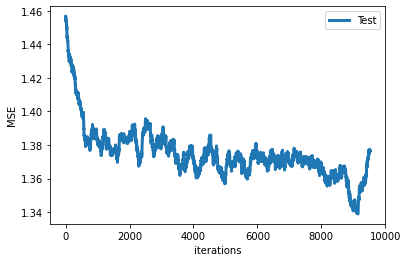

In [25]:
plot_learning_curve(als)

In [26]:
als.test_mse_record[-1]

1.3765123397141528